In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sklearn
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import r2_score

## Data Loading and Cleaning

In [6]:
data=pd.read_csv('Zephyr Data Emo with new categories.csv', engine="python", delimiter=';')

In [11]:
data.head(3)

Year  Month   Weekday  Hour  HR  BR  Posture  Activity  \
Time                                                                          
2020-03-26 09:02:28  2020  March  Thursday     9  79  15       16      0.01   
2020-03-26 09:02:29  2020  March  Thursday     9  79  15       16      0.01   
2020-03-26 09:02:30  2020  March  Thursday     9  79  15       17      0.01   

                     PeakAcceleration  BRAmplitude  ...  JumpFlightTime  \
Time                                                ...                   
2020-03-26 09:02:28              0.02         2593  ...               0   
2020-03-26 09:02:29              0.10         2163  ...               0   
2020-03-26 09:02:30              0.03         1943  ...               0   

                     PeakAccelPhi  peakAccelTheta  \
Time                                                
2020-03-26 09:02:28           163             -50   
2020-03-26 09:02:29           168             -87   
2020-03-26 09:02:30           164             -47   

                                            Activities  Activities Detailed  \
Time                                                                          
2020-03-26 09:02:28  900 trining working 1930 training                sport   
2020-03-26 09:02:29  900 trining working 1930 training                sport   
2020-03-26 09:02:30  900 trining working 1930 training                sport   

                     Controled stress   stress  Before Controled stress  \
Time                                                                      
2020-03-26 09:02:28               1.0      0.0                      0.0   
2020-03-26 09:02:29               1.0      0.0                      0.0   
2020-03-26 09:02:30               1.0      0.0                      0.0   

                     After controlled stress  Name of the volunteer  
Time                                                                 
2020-03-26 09:02:28                      0.0                     EM  
2020-03-26 09:02:29                      0.0                     EM  
2020-03-26 09:02:30                      0.0                     EM  

[3 rows x 36 columns]

There are only for persons and some activities are overpresented compared to others. 

In [3]:
print(data['Name of the volunteer'].unique())

['EM' 'AB' 'NP' 'VM']


We need to clean the data by handling missing values, strings to floating numbers, standardization or normalization.

In [7]:
#to be run only once
data.fillna(0, inplace=True)
data.set_index('Time', inplace=True)
data.index = pd.to_datetime(data.index, format='%d.%m.%Y %H:%M:%S')

In [6]:
type(data['Activity'].iloc[0])

str

In [8]:
data['Activity'] = data['Activity'].str.replace(',', '.')
data['Activity'] = data['Activity'].astype(float)

data['PeakAcceleration'] = data['PeakAcceleration'].str.replace(',', '.')
data['PeakAcceleration'] = data['PeakAcceleration'].astype(float)

data['ECGAmplitude'] = data['ECGAmplitude'].str.replace(',', '.')
data['ECGAmplitude'] = data['ECGAmplitude'].astype(float)

data['ECGNoise'] = data['ECGNoise'].str.replace(',', '.')
data['ECGNoise'] = data['ECGNoise'].astype(float)

data['CoreTemp'] = data['CoreTemp'].str.replace(',', '.')
data['CoreTemp'] = data['CoreTemp'].astype(float)

data['AvForceDevRate'] = data['AvForceDevRate'].str.replace(',', '.')
data['AvForceDevRate'] = data['AvForceDevRate'].astype(float)

data['AvStepImpulse'] = data['AvStepImpulse'].str.replace(',', '.')
data['AvStepImpulse'] = data['AvStepImpulse'].astype(float)

data['AvStepPeriod'] = data['AvStepPeriod'].str.replace(',', '.')
data['AvStepPeriod'] = data['AvStepPeriod'].astype(float)

In [8]:
data.columns.tolist()

['Year',
 'Month',
 'Weekday',
 'Hour',
 'HR',
 'BR',
 'Posture',
 'Activity',
 'PeakAcceleration',
 'BRAmplitude',
 'ECGAmplitude',
 'ECGNoise',
 'HRConfidence',
 'HRV',
 'CoreTemp',
 'ImpulseLoad',
 'WalkSteps',
 'RunSteps',
 'Bounds',
 'Jumps',
 'MinorImpacts',
 'Date',
 'MajorImpacts',
 'AvForceDevRate',
 'AvStepImpulse',
 'AvStepPeriod',
 'JumpFlightTime',
 'PeakAccelPhi',
 'peakAccelTheta',
 'Activities',
 'Activities Detailed',
 'Controled stress',
 ' stress',
 'Before Controled stress',
 'After controlled stress',
 'Name of the volunteer']

In [136]:
category_counts = data['Activities Detailed'].value_counts()
category_counts

office work            72104
sport                  69753
dream                  66155
public speaking        10673
sales                   7949
negotiation             7612
creative writing        4927
training                4197
phone calls             4076
competition             3650
presentation            3324
reading book            3307
play piano              3180
cognitive workout       3067
meeting with client     2624
leisure                 1768
Play Quitar              642
writing study            558
walking meeting          284
Coherent Breathing        88
Name: Activities Detailed, dtype: int64

In [9]:
data = data[data['Activities Detailed'] != 'papper work']

In [138]:
labels_to_exclude = category_counts[category_counts < 1500].index
data = data[~data['Activities Detailed'].isin(labels_to_exclude)]

In [139]:
print('No of duplicates in data: {}'.format(sum(data.duplicated())))
data = data.drop_duplicates()

print('No of duplicates in data after removal: {}'.format(sum(data.duplicated())))

No of duplicates in data: 0
No of duplicates in data after removal: 0


In [10]:
data = data[data['HRConfidence'] >= 20]

In [12]:
data.to_csv('Zephyr.csv', index=False)

# Exploratory Data Analysis

First we notice that data comes from mainly from one user: 'EM'

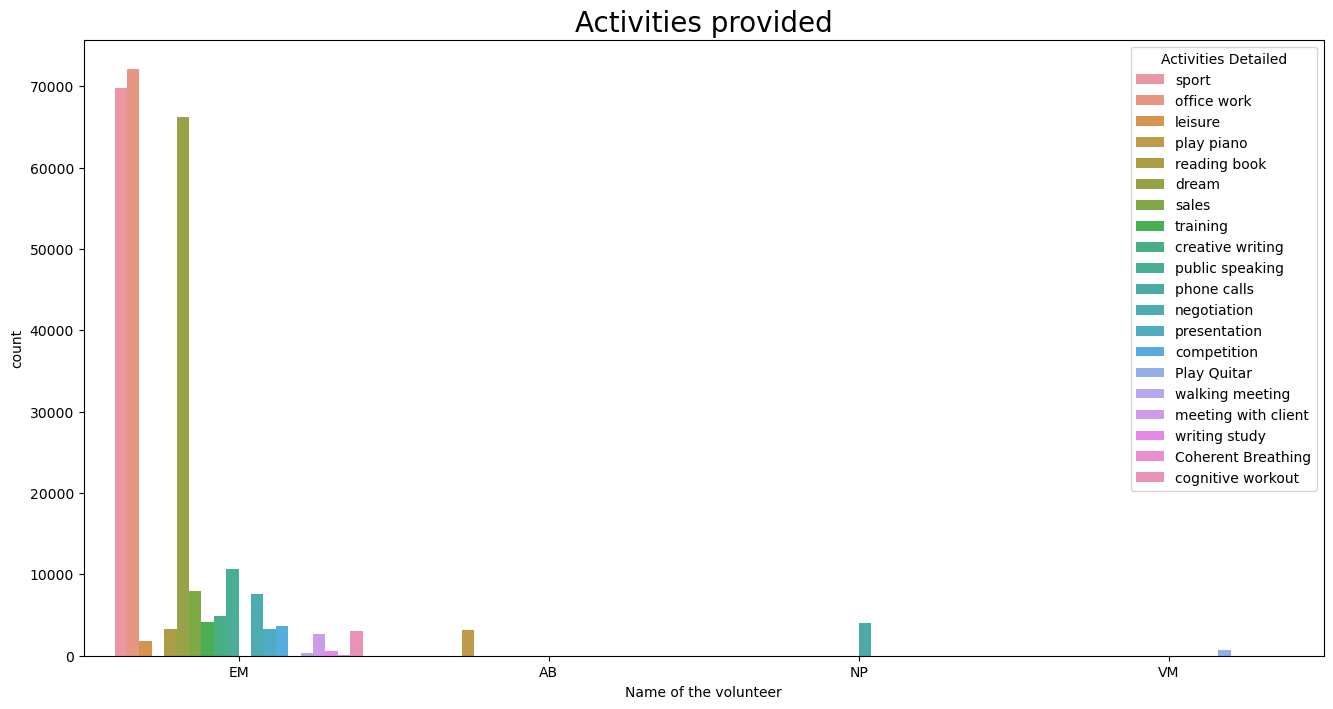

In [21]:
plt.figure(figsize=(16,8))
plt.title('Activities provided', fontsize=20)
sns.countplot(x='Name of the volunteer',hue='Activities Detailed', data = data)
plt.show()

Next, we can see that the most frequent activities are sport,office work and dream, i.e. our data is not balanced.

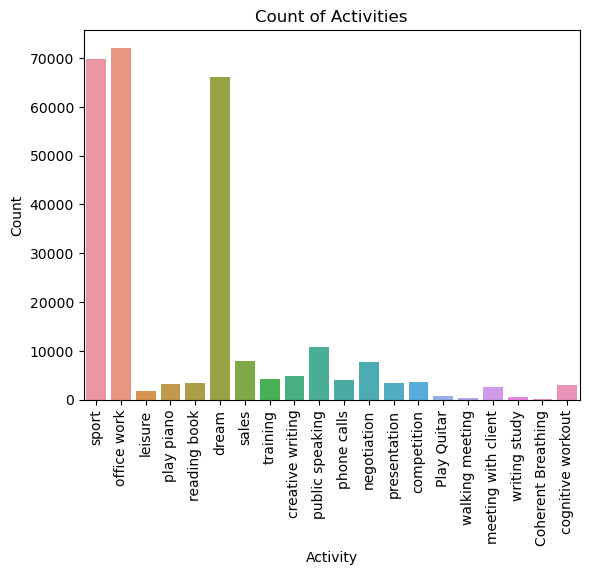

In [25]:
plt.title('No of Datapoints per Activity', fontsize=15)
sns.countplot(data=data, x='Activities Detailed')
plt.title('Count of Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.show()

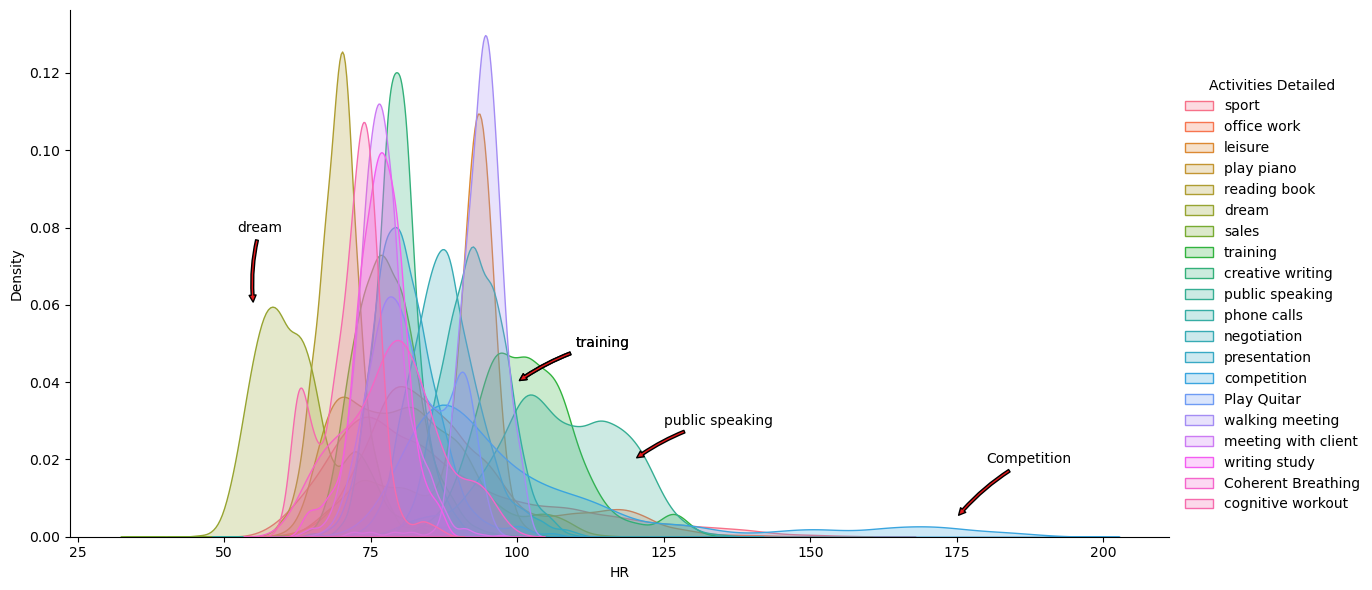

In [58]:
sns.set_palette("Set1", desat=1)

# Create a FacetGrid
facetgrid = sns.FacetGrid(data, hue='Activities Detailed', height=6, aspect=2)

# Map the distribution plot
facetgrid.map(sns.kdeplot, 'HR', fill=True)

# Add legend
facetgrid.add_legend()

# Annotations
plt.annotate("dream", xy=(55, 0.06), xytext=(60, 0.08),
             xycoords='data', textcoords='data',
             va='center', ha='right',
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

plt.annotate("Competition", xy=(175, 0.005), xytext=(180, 0.02),
             xycoords='data', textcoords='data',
             va='center', ha='left',
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

plt.annotate("training", xy=(100, 0.04), xytext=(110, 0.05),
             xycoords='data', textcoords='data',
             va='center', ha='left',
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

plt.annotate("training", xy=(100, 0.04), xytext=(110, 0.05),
             xycoords='data', textcoords='data',
             va='center', ha='left',
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

plt.annotate("public speaking", xy=(120, 0.02), xytext=(125, 0.03),
             xycoords='data', textcoords='data',
             va='center', ha='left',
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

# Show the plot
plt.show()

In [38]:
groups = data.groupby('Activities Detailed')

# Create an empty dictionary to store the smaller dataframes
smaller_dfs = {}

# Iterate over each group and create separate dataframes
for label, group_df in groups:
    smaller_dfs[label] = group_df.copy()

<Figure size 1000x600 with 0 Axes>

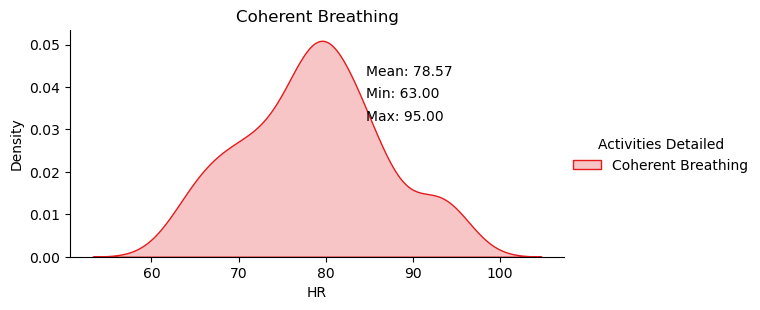

<Figure size 1000x600 with 0 Axes>

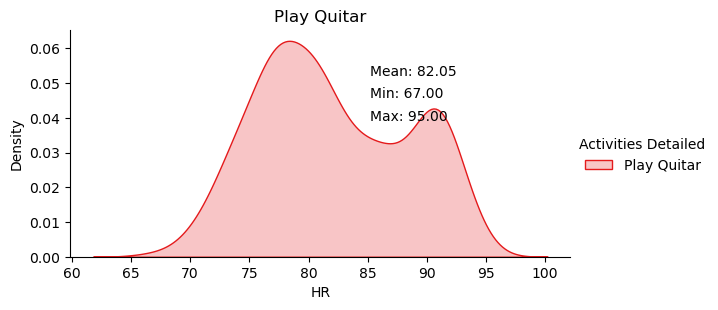

<Figure size 1000x600 with 0 Axes>

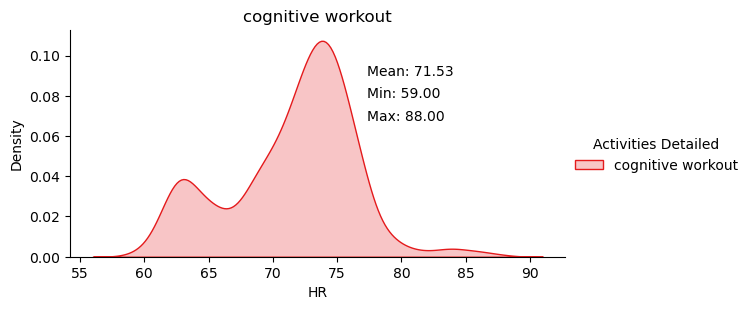

<Figure size 1000x600 with 0 Axes>

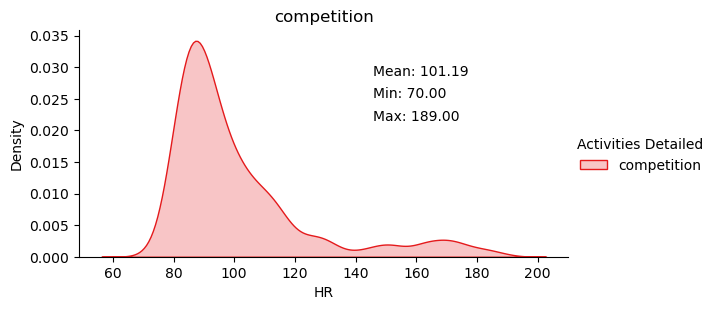

<Figure size 1000x600 with 0 Axes>

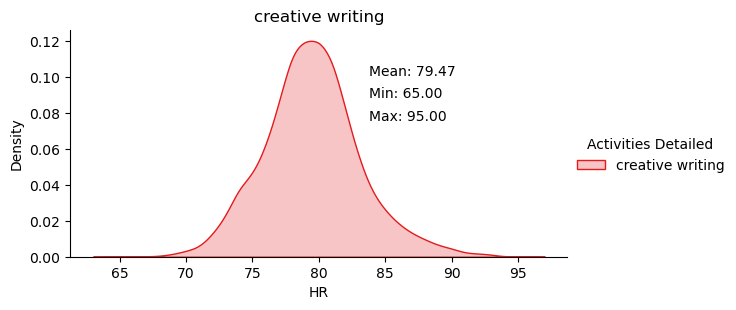

<Figure size 1000x600 with 0 Axes>

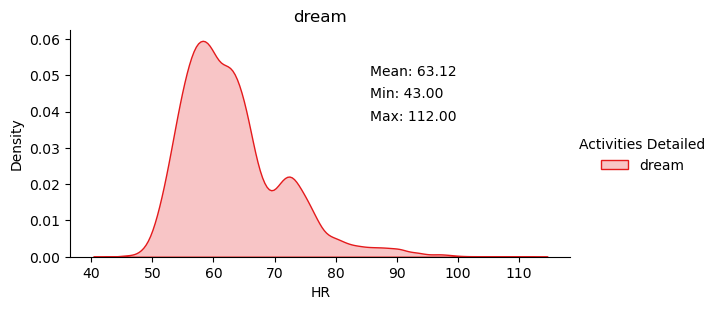

<Figure size 1000x600 with 0 Axes>

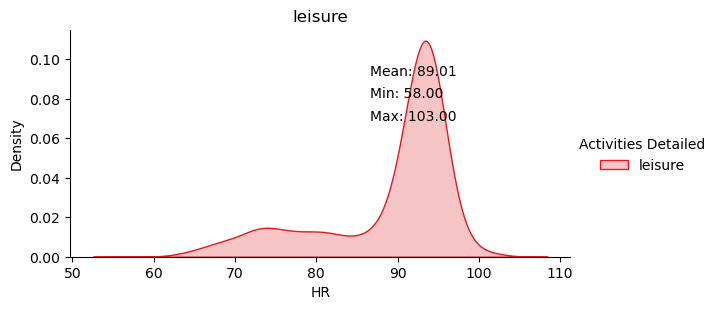

<Figure size 1000x600 with 0 Axes>

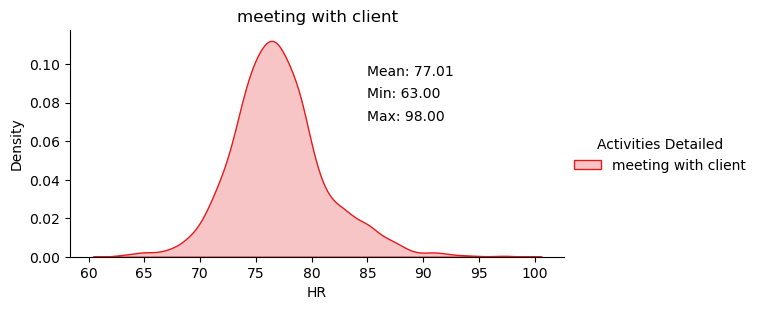

<Figure size 1000x600 with 0 Axes>

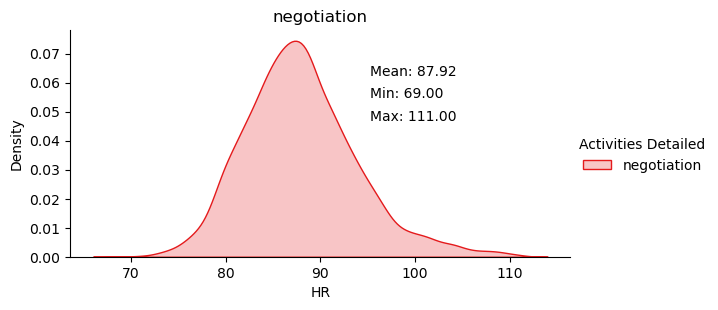

<Figure size 1000x600 with 0 Axes>

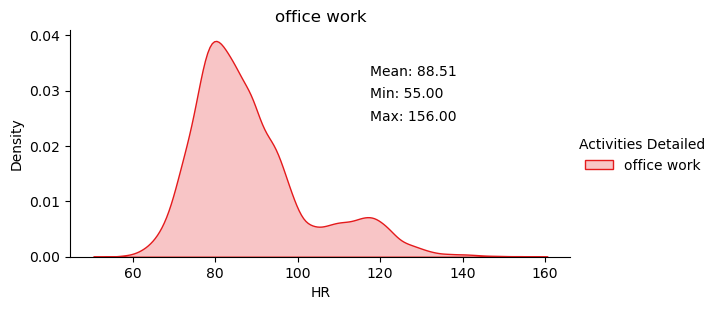

<Figure size 1000x600 with 0 Axes>

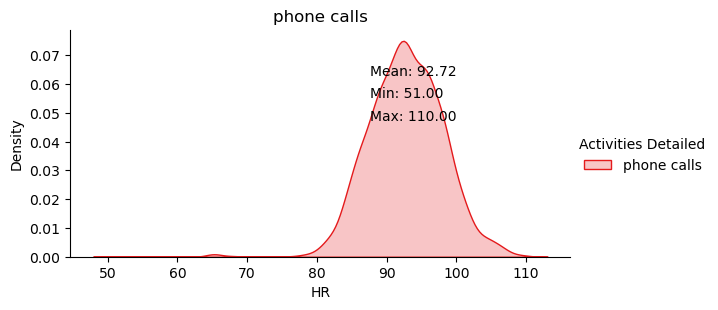

<Figure size 1000x600 with 0 Axes>

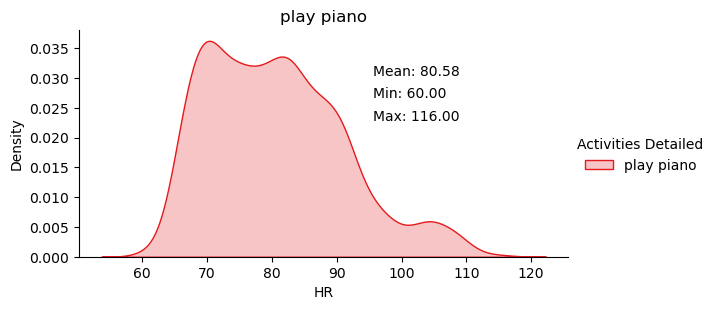

<Figure size 1000x600 with 0 Axes>

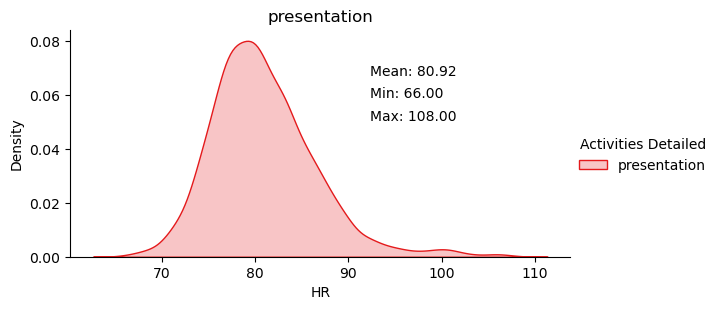

<Figure size 1000x600 with 0 Axes>

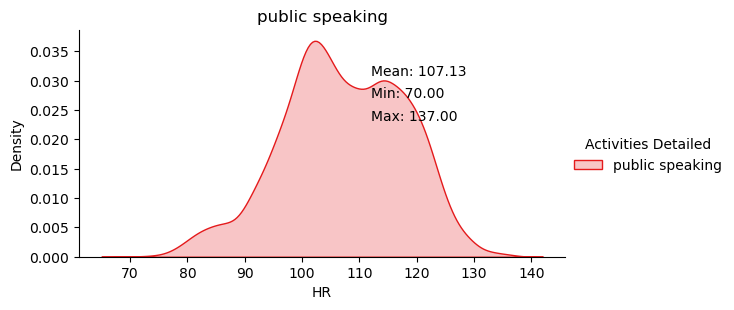

<Figure size 1000x600 with 0 Axes>

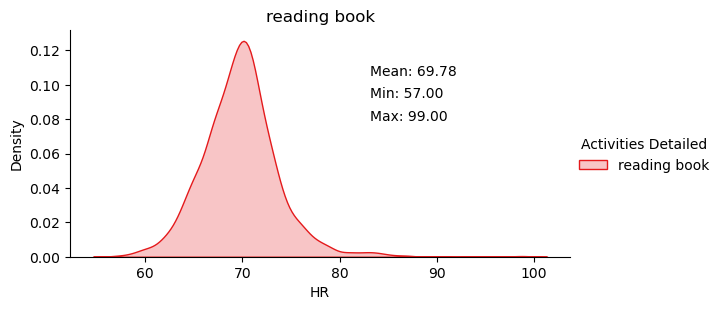

<Figure size 1000x600 with 0 Axes>

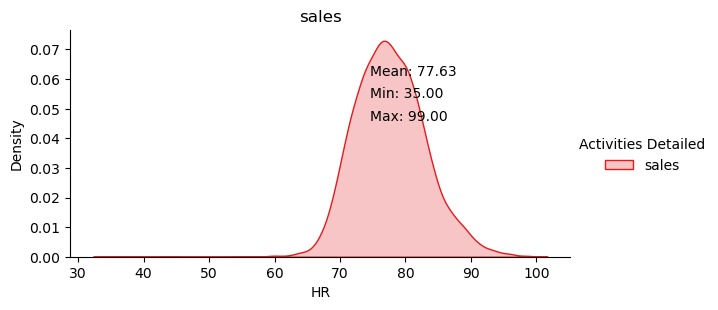

<Figure size 1000x600 with 0 Axes>

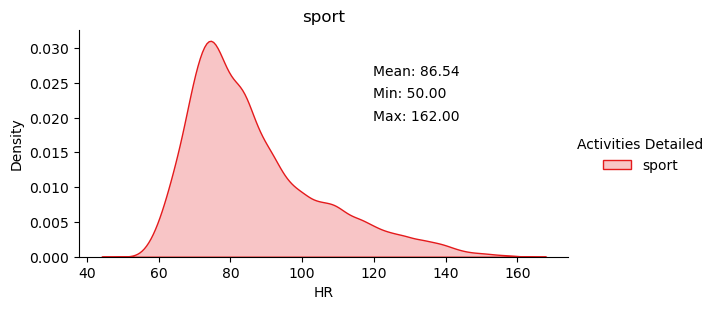

<Figure size 1000x600 with 0 Axes>

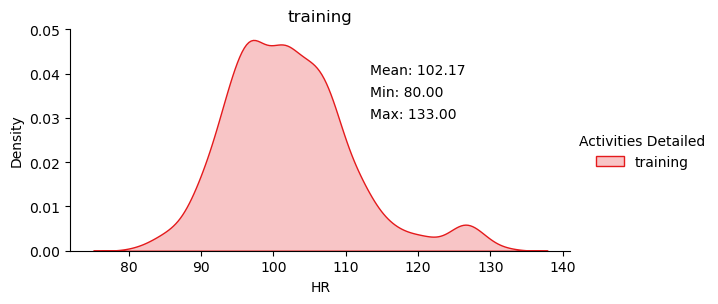

<Figure size 1000x600 with 0 Axes>

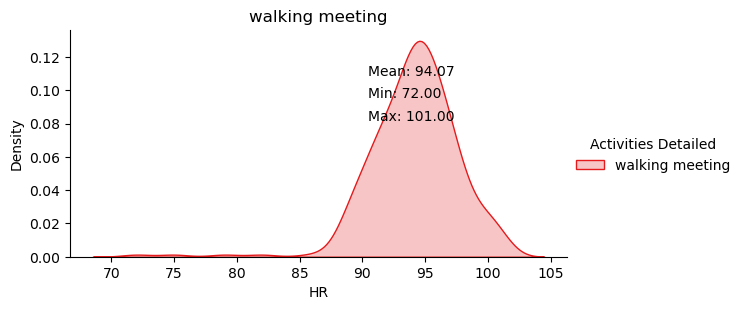

<Figure size 1000x600 with 0 Axes>

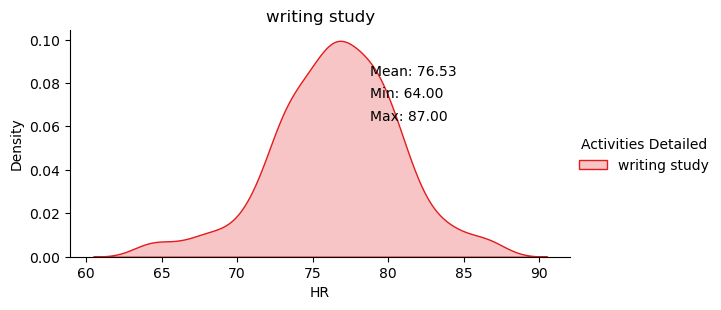

In [56]:
sns.set_palette("Set1", desat=1)

# Iterate over each label and corresponding dataframe
for label, df in smaller_dfs.items():
    # Create a new plot for each dataframe
    plt.figure(figsize=(10, 6))

    # Create a FacetGrid for the current dataframe
    facetgrid = sns.FacetGrid(df, hue='Activities Detailed', height=3, aspect=2)

    # Map the distribution plot
    facetgrid.map(sns.kdeplot, 'HR', fill=True)

    # Add legend
    facetgrid.add_legend()
    
    mean_val = df['HR'].mean()
    min_val = df['HR'].min()
    max_val = df['HR'].max()

    # Add text annotations for mean, min, and max values
    plt.text(0.6, 0.8, f"Mean: {mean_val:.2f}", transform=plt.gca().transAxes)
    plt.text(0.6, 0.7, f"Min: {min_val:.2f}", transform=plt.gca().transAxes)
    plt.text(0.6, 0.6, f"Max: {max_val:.2f}", transform=plt.gca().transAxes)


    # Set title
    plt.title(label)

    # Show the plot
    plt.show()

From these plots we can see that:
* Competition, Training and Sport are right skewed - most of the time the heart rate is in range 50-80 and there are some instances of excessively high heart rate of 130-160

<Figure size 1000x600 with 0 Axes>

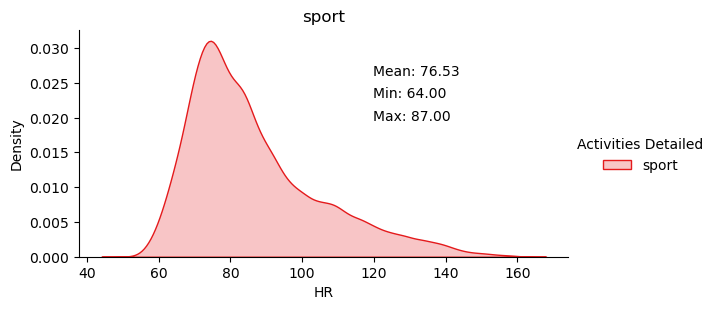

In [130]:
plt.figure(figsize=(10, 6))
sns.set_palette("Set1", desat=1)
facetgrid = sns.FacetGrid(smaller_dfs['sport'], hue='Activities Detailed', height=3, aspect=2)
facetgrid.map(sns.kdeplot, 'HR', fill=True)
facetgrid.add_legend()
mean_val = df['HR'].mean()
min_val = df['HR'].min()
max_val = df['HR'].max()

# Add text annotations for mean, min, and max values
plt.text(0.6, 0.8, f"Mean: {mean_val:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.7, f"Min: {min_val:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.6, f"Max: {max_val:.2f}", transform=plt.gca().transAxes)

plt.title('sport')
plt.show()    




* Meeting with client, Negotiation, Creative writing are normaly distributed with a heart rate usually around 80 

<Figure size 1000x600 with 0 Axes>

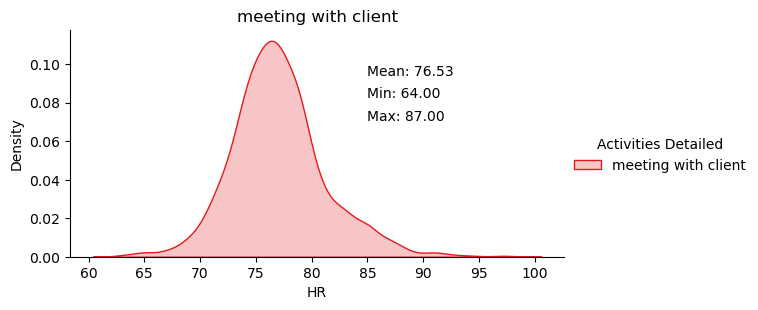

In [132]:
plt.figure(figsize=(10, 6))
sns.set_palette("Set1", desat=1)
facetgrid = sns.FacetGrid(smaller_dfs['meeting with client'], hue='Activities Detailed', height=3, aspect=2)
facetgrid.map(sns.kdeplot, 'HR', fill=True)
facetgrid.add_legend()
mean_val = df['HR'].mean()
min_val = df['HR'].min()
max_val = df['HR'].max()

# Add text annotations for mean, min, and max values
plt.text(0.6, 0.8, f"Mean: {mean_val:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.7, f"Min: {min_val:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.6, f"Max: {max_val:.2f}", transform=plt.gca().transAxes)

plt.title('meeting with client')
plt.show() 

* Some activities exhibit bimodal distributions (Play guitar, Play Piano, Cognitive Workout) 

<Figure size 1000x600 with 0 Axes>

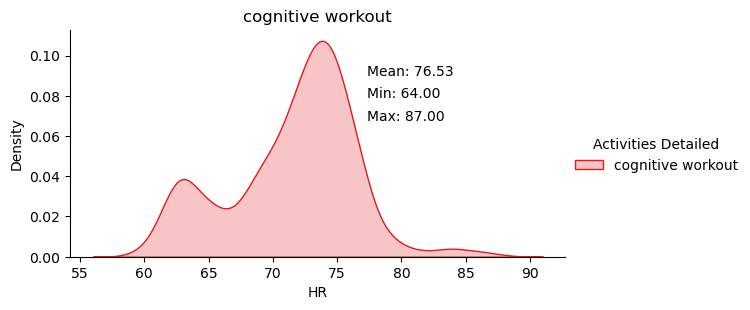

In [134]:
plt.figure(figsize=(10, 6))
sns.set_palette("Set1", desat=1)
facetgrid = sns.FacetGrid(smaller_dfs['cognitive workout'], hue='Activities Detailed', height=3, aspect=2)
facetgrid.map(sns.kdeplot, 'HR', fill=True)
facetgrid.add_legend()
mean_val = df['HR'].mean()
min_val = df['HR'].min()
max_val = df['HR'].max()

# Add text annotations for mean, min, and max values
plt.text(0.6, 0.8, f"Mean: {mean_val:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.7, f"Min: {min_val:.2f}", transform=plt.gca().transAxes)
plt.text(0.6, 0.6, f"Max: {max_val:.2f}", transform=plt.gca().transAxes)

plt.title('cognitive workout')
plt.show() 

We can see detect better potential outliers with boxplots 

In [66]:
#choose only numerical data for correlation
columns_to_exclude = ['Year','Month', 'Weekday', 'Hour', 'Activities','Name of the volunteer']
numerical_columns  = data.drop(columns=columns_to_exclude)
numerical_columns = numerical_columns.select_dtypes(include=[np.number])  # Select numerical columns
non_binary_columns = numerical_columns.loc[:, ~(numerical_columns.isin([0, 1])).all()]  # Exclude columns with only 0s and 1s
# Exclude these columns as they don't provide important information
#columns_to_exclude = ['Year', 'Hour']

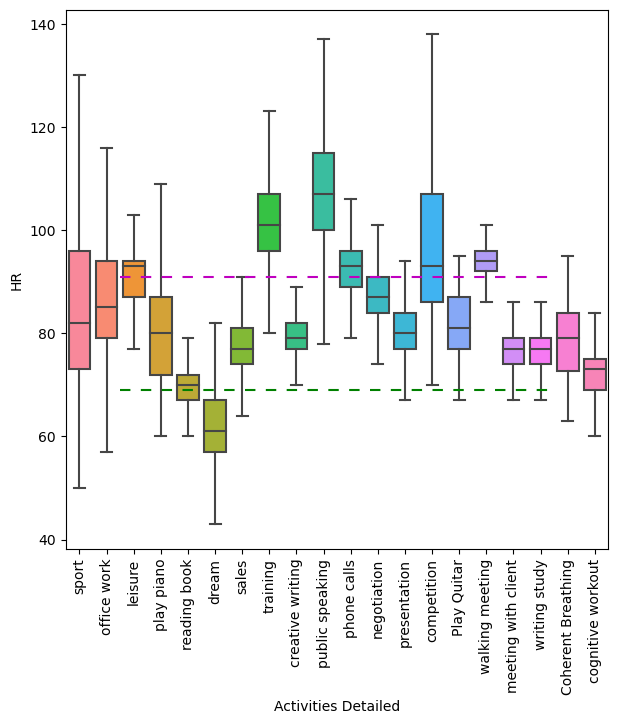

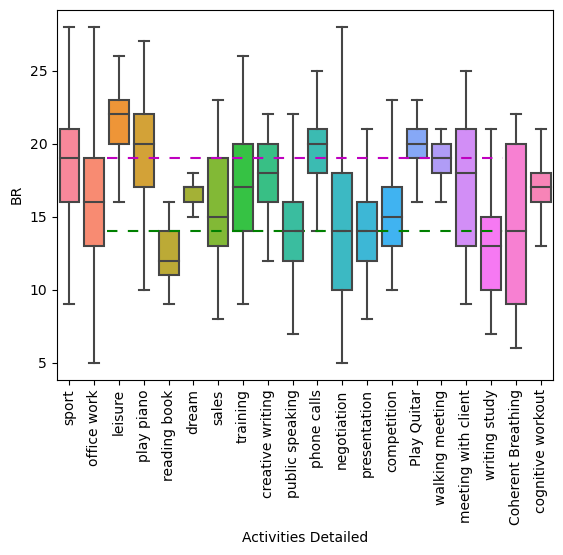

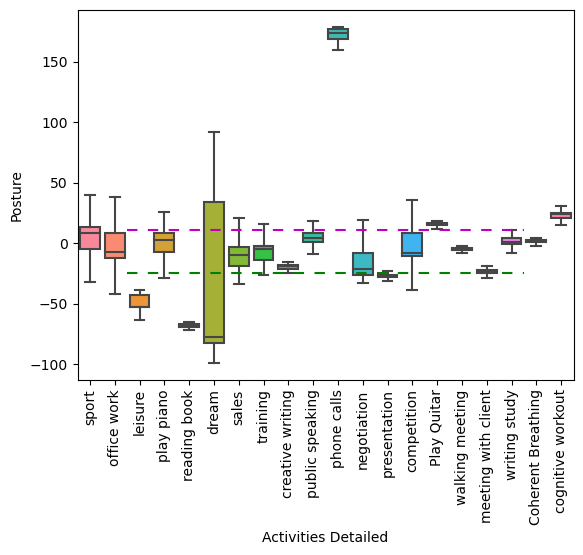

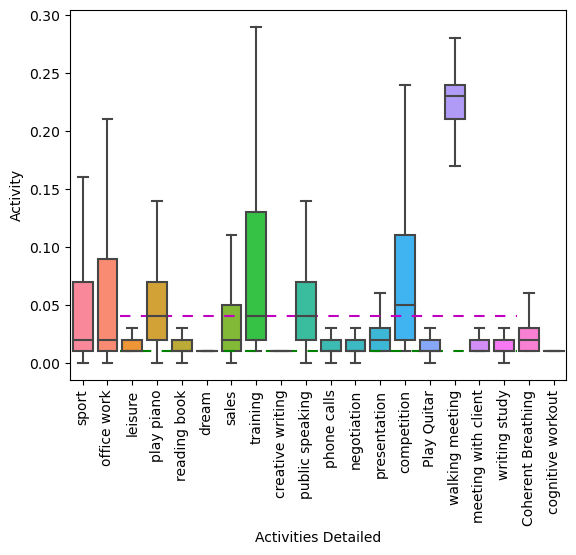

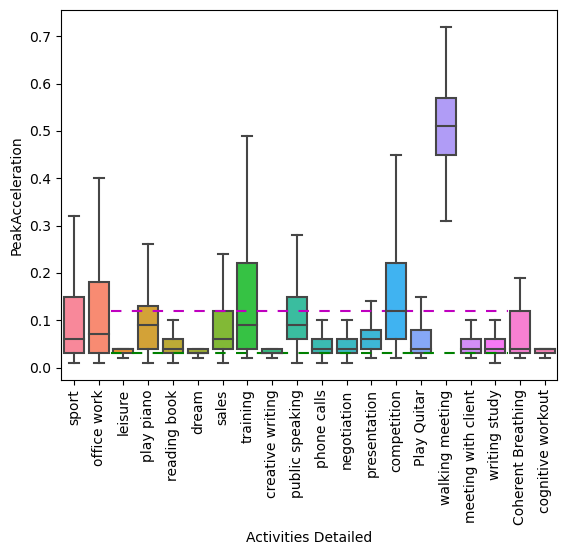

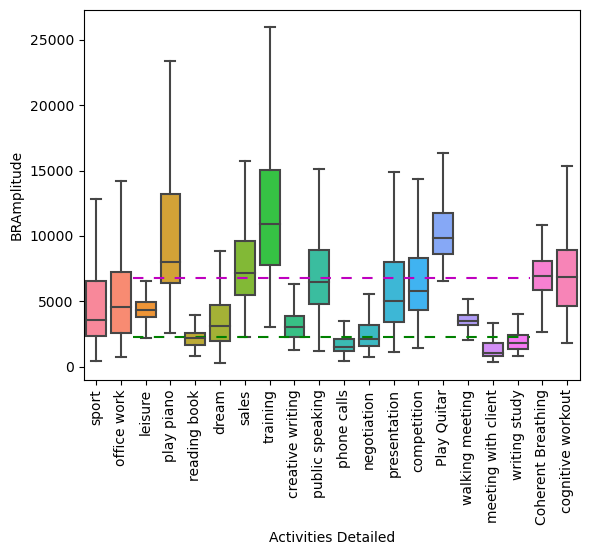

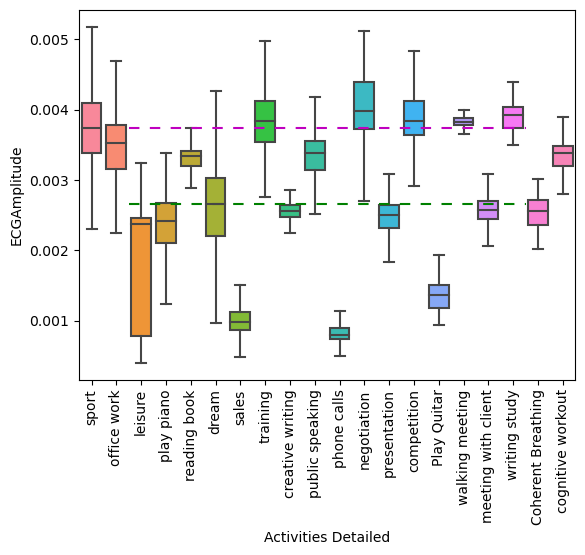

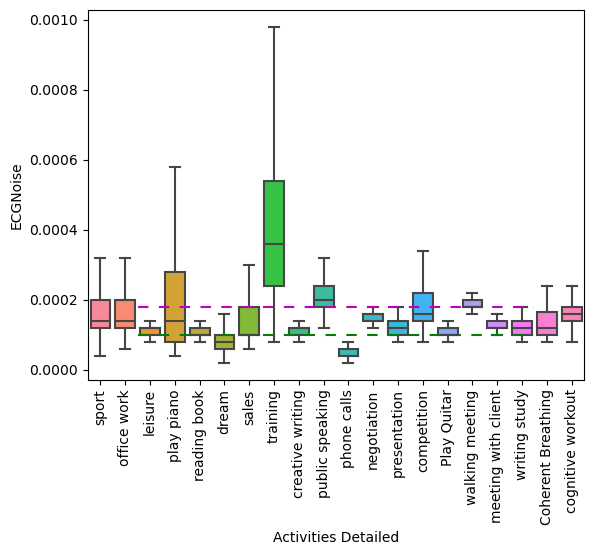

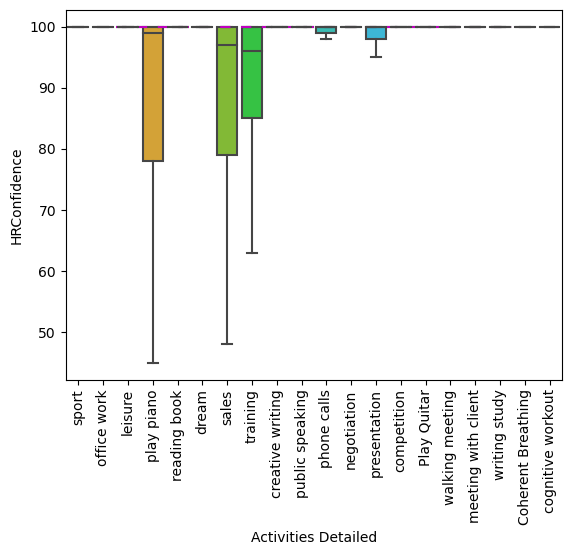

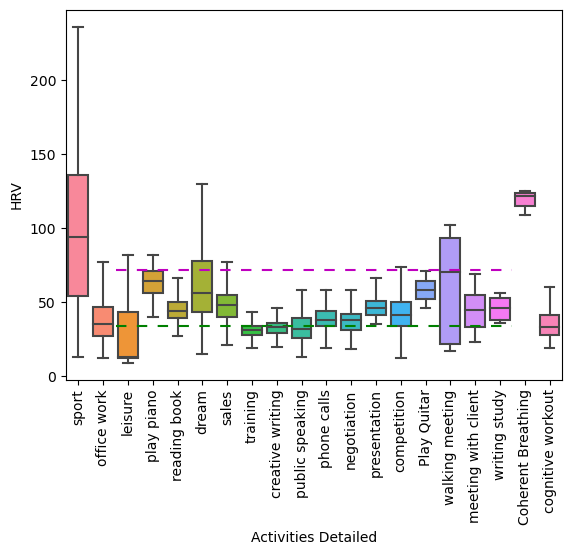

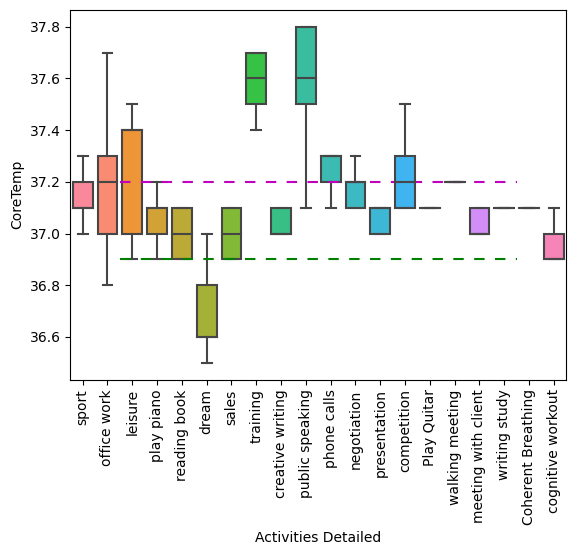

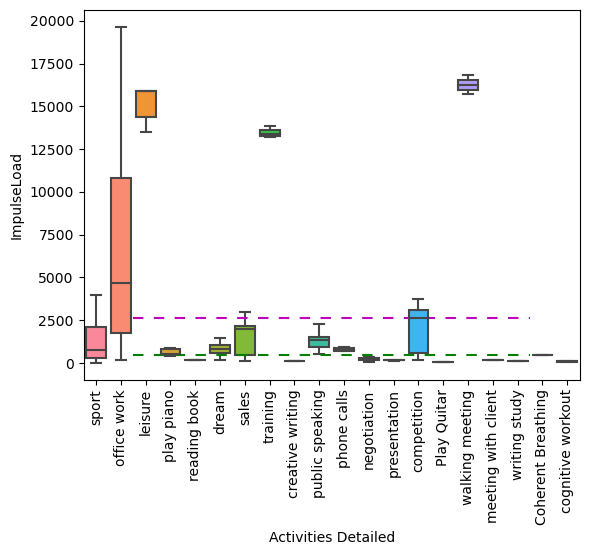

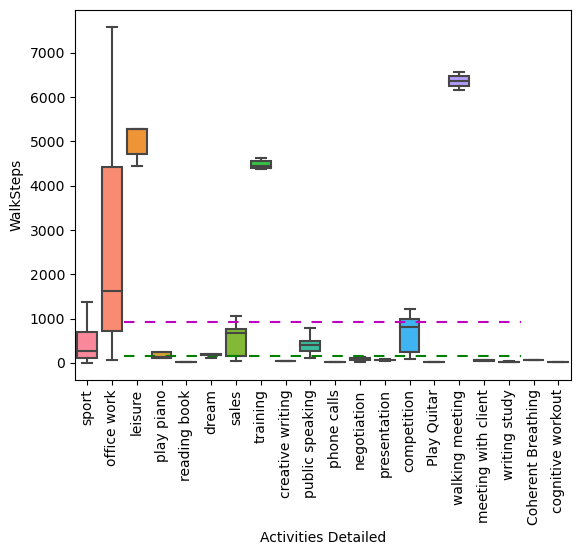

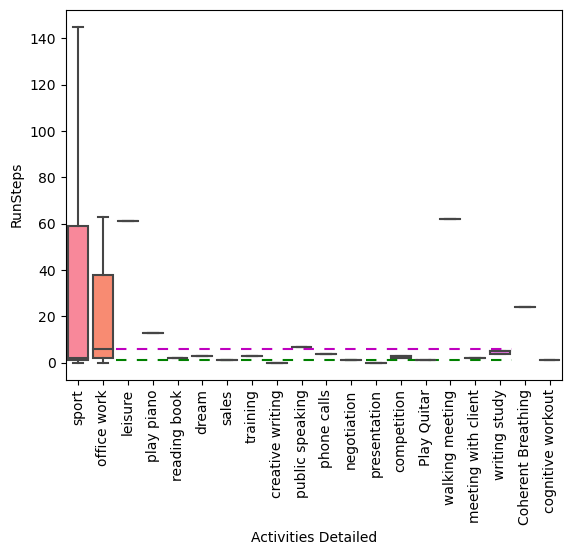

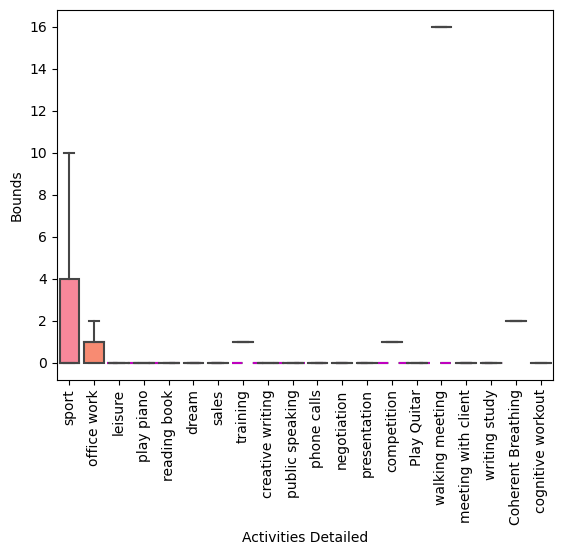

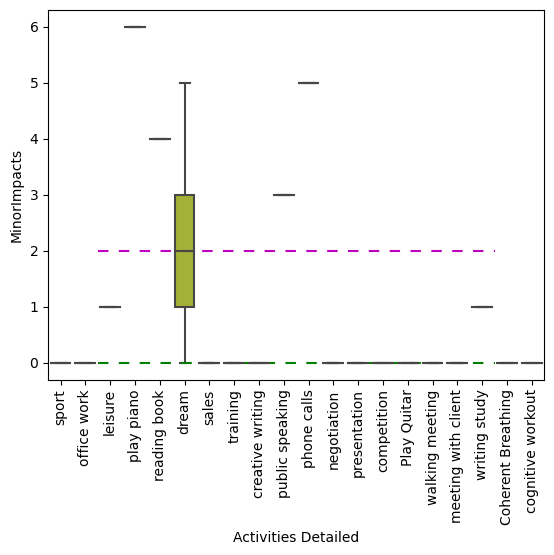

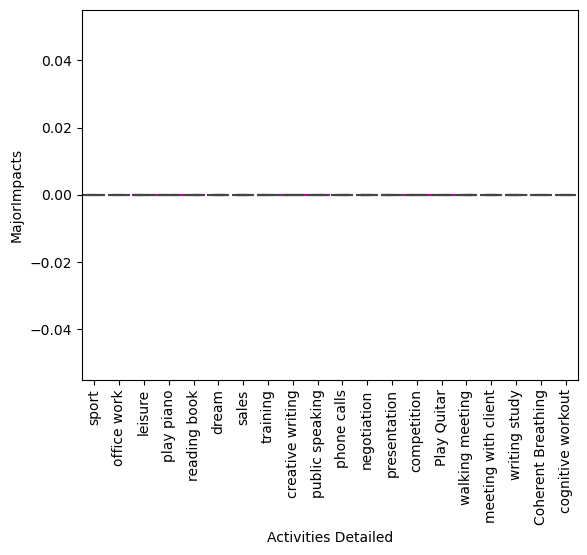

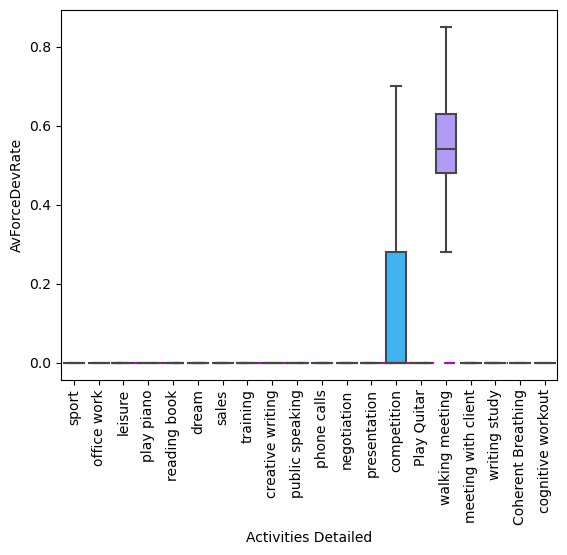

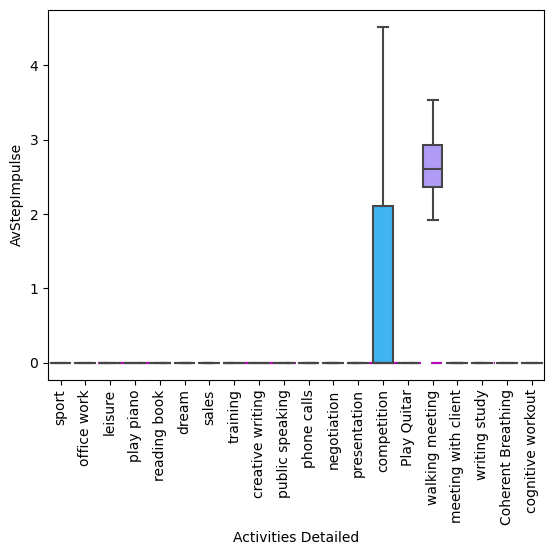

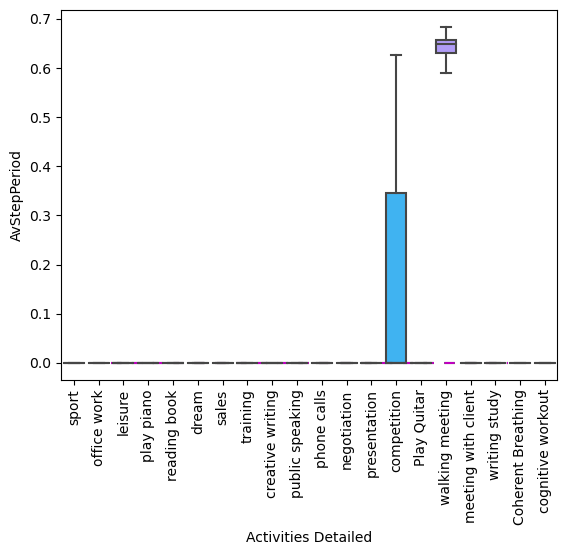

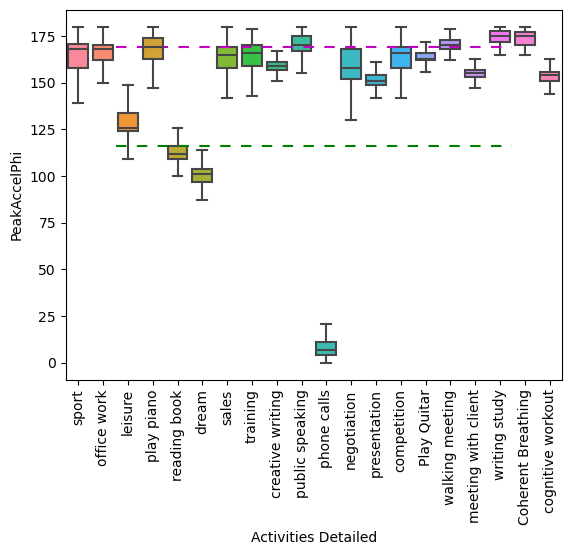

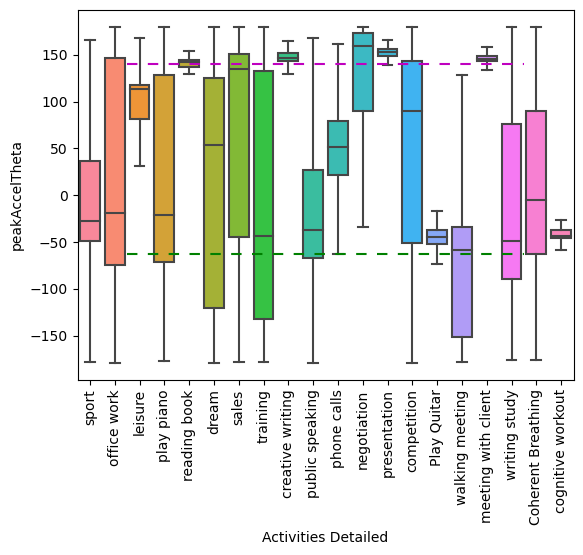

In [69]:
# Create boxplots for each activity and variable
plt.figure(figsize=(7, 7))

# Iterate over each numeric column
# Iterate over each numeric column
for column in non_binary_columns:
        # Calculate the 25th and 75th quartiles
        quartile_25 = np.percentile(data[column], 25)
        quartile_75 = np.percentile(data[column], 75)

        # Create a boxplot for each column
        sns.boxplot(x='Activities Detailed', y=column, data=data, showfliers=False, saturation=1)
        plt.ylabel(column)
        plt.axhline(y=quartile_25, xmin=0.1, xmax=0.9, dashes=(5, 5), c='g')
        plt.axhline(y=quartile_75, xmin=0.1, xmax=0.9, dashes=(5, 5), c='m')
        plt.xticks(rotation=90)
        plt.show()

From the boxplots we can see again that the variables are rarely normally distributed with many instances above the 75th quartile.

## Correlation Analysis

In [96]:
#choose only numerical data for correlation
columns_to_exclude = ['Year','Month', 'Weekday', 'Hour', 'Activities', 'Activities Detailed','Name of the volunteer']
numerical_columns  = data.drop(columns=columns_to_exclude)
numerical_columns = numerical_columns.select_dtypes(include=[np.number])  # Select numerical columns
non_binary_columns = numerical_columns.loc[:, ~(numerical_columns.isin([0, 1])).all()]  # Exclude columns with only 0s and 1s
# Exclude these columns as they don't provide important information
#columns_to_exclude = ['Year', 'Hour']

In [97]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [98]:
non_binary_columns = feature_normalize(non_binary_columns)

In [10]:
correlation_matrix = non_binary_columns.corr()

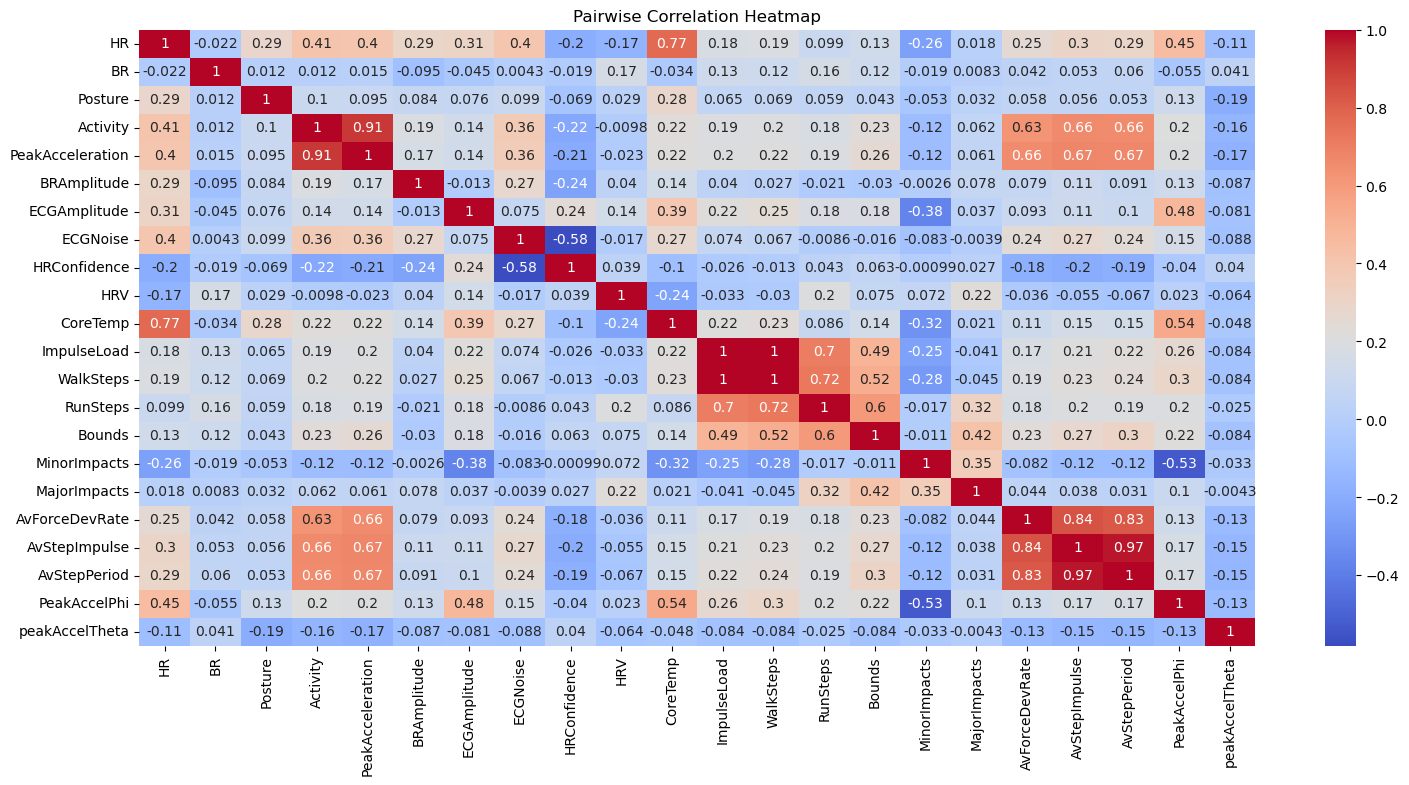

In [11]:
# Create the heatmap
plt.figure(figsize=(18, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the plot title
plt.title('Pairwise Correlation Heatmap')

# Show the plot
plt.show()

<Axes: xlabel='HR', ylabel='CoreTemp'>

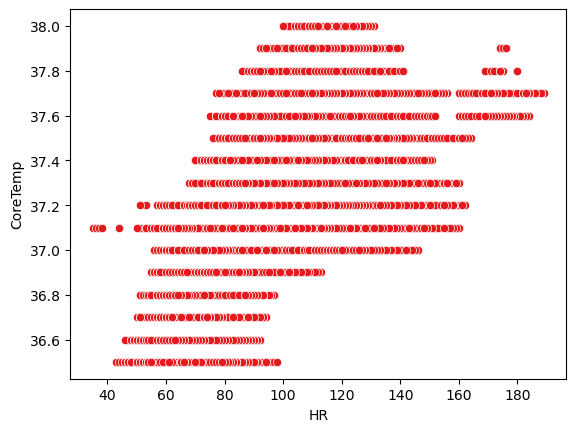

In [71]:
sns.scatterplot(x=non_binary_columns['HR'],y=non_binary_columns['CoreTemp'])

<Axes: xlabel='RunSteps', ylabel='Bounds'>

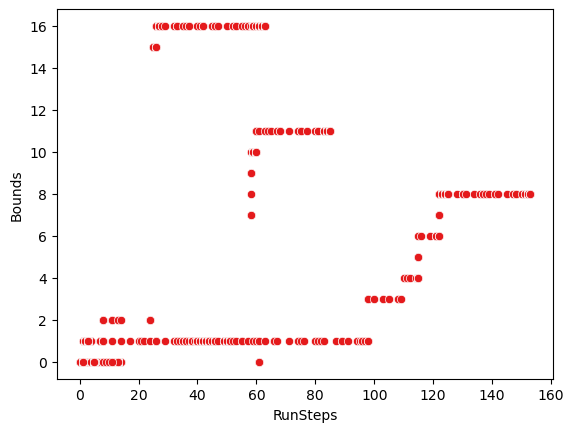

In [72]:
sns.scatterplot(x=data['RunSteps'],y=data['Bounds'])

<Axes: xlabel='HR', ylabel='ECGNoise'>

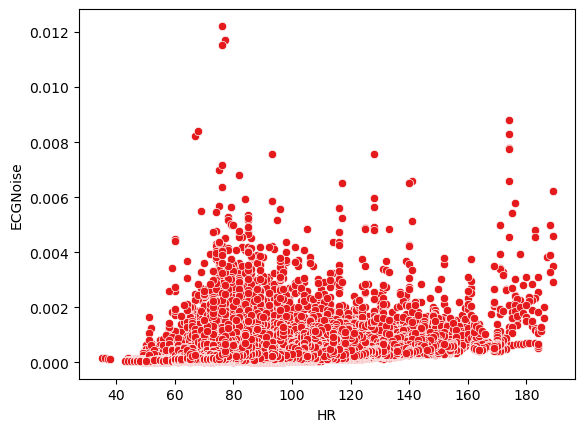

In [73]:
sns.scatterplot(x=data['HR'],y=data['ECGNoise'])

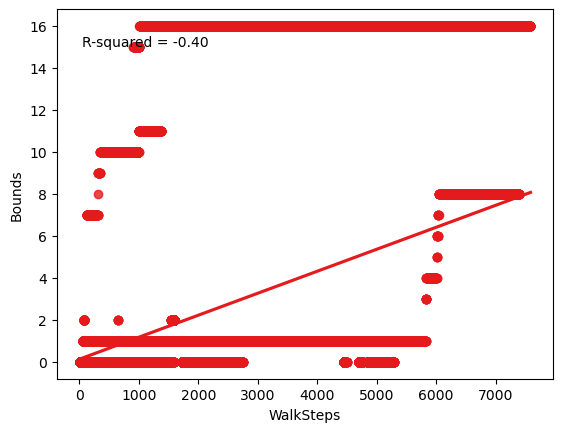

In [74]:
sns.regplot(x='WalkSteps', y='Bounds', data=data)

# Calculate the R-squared value
r_squared = r2_score(data['WalkSteps'], data['Bounds'])

# Annotate the R-squared value on the plot
plt.annotate(f'R-squared = {r_squared:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
# Show the plot
plt.show()

It is hard to see any correlation simply from the plots between any of the variables. These will be analyzed via clustering and pca as a next step

## Clustering Analysis

In [ ]:
#choose only numerical data for correlation
columns_to_exclude = ['Year','Month', 'Weekday', 'Hour', 'Activities', 'Activities Detailed','Name of the volunteer']
numerical_columns  = data.drop(columns=columns_to_exclude)
numerical_columns = numerical_columns.select_dtypes(include=[np.number])  # Select numerical columns
non_binary_columns = numerical_columns.loc[:, ~(numerical_columns.isin([0, 1])).all()]  # Exclude columns with only 0s and 1s
# Exclude these columns as they don't provide important information
#columns_to_exclude = ['Year', 'Hour']

In [101]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(non_binary_columns), columns=non_binary_columns.columns, index=non_binary_columns.index )

In [102]:
df_scaled

HR        BR   Posture  Activity  PeakAcceleration  \
Time                                                                          
26.3.2020 9:02:28 -0.149289 -0.460424  0.554181 -0.496950         -0.614135   
26.3.2020 9:02:29 -0.149289 -0.460424  0.554181 -0.496950         -0.020906   
26.3.2020 9:02:30 -0.149289 -0.460424  0.575993 -0.496950         -0.539982   
26.3.2020 9:02:31 -0.149289 -0.460424  0.575993 -0.496950         -0.614135   
26.3.2020 9:02:32 -0.149289 -0.460424  0.575993 -0.637166         -0.614135   
...                     ...       ...       ...       ...               ...   
22.6.2022 6:35:10  0.126611  0.892923 -0.536417 -0.076300         -0.169214   
22.6.2022 6:35:11  0.126611  0.892923 -0.558229 -0.496950         -0.539982   
22.6.2022 6:35:12  0.126611  0.622254 -0.580041 -0.076300          0.646476   
22.6.2022 6:35:13  0.181791  0.622254 -0.623665  0.063917         -0.095060   
22.6.2022 6:35:14  0.181791  0.622254 -0.667289  0.204133         -0.020906   

                   BRAmplitude  ECGAmplitude   ECGNoise  HRConfidence  \
Time                                                                    
26.3.2020 9:02:28    -0.520211     -0.839598  -0.354194      0.257222   
26.3.2020 9:02:29    -0.593711     -0.883906  -0.354194      0.257222   
26.3.2020 9:02:30    -0.631316     -0.883906  -0.354194      0.257222   
26.3.2020 9:02:31    -0.615078     -0.906061  -0.354194      0.257222   
26.3.2020 9:02:32    -0.660887     -0.906061  -0.354194      0.257222   
...                        ...           ...        ...           ...   
22.6.2022 6:35:10     4.431823      0.423204   3.499207     -4.646147   
22.6.2022 6:35:11     5.842001      0.423204   2.273125     -5.091908   
22.6.2022 6:35:12     6.964161      0.423204   3.586784     -5.760549   
22.6.2022 6:35:13     7.438494      0.334587  10.768121     -6.094869   
22.6.2022 6:35:14     6.015838      0.334587  10.330235     -6.652070   

                        HRV  ...  WalkSteps  RunSteps    Bounds  MinorImpacts  \
Time                         ...                                                
26.3.2020 9:02:28 -0.391779  ...  -0.616980 -0.466675 -0.369193     -0.625369   
26.3.2020 9:02:29 -0.391779  ...  -0.616980 -0.466675 -0.369193     -0.625369   
26.3.2020 9:02:30 -0.391779  ...  -0.616980 -0.466675 -0.369193     -0.625369   
26.3.2020 9:02:31 -0.391779  ...  -0.616980 -0.466675 -0.369193     -0.625369   
26.3.2020 9:02:32 -0.391779  ...  -0.616980 -0.466675 -0.369193     -0.625369   
...                     ...  ...        ...       ...       ...           ...   
22.6.2022 6:35:10 -0.571145  ...  -0.620719 -0.466675 -0.369193      0.016063   
22.6.2022 6:35:11 -0.545522  ...  -0.620719 -0.466675 -0.369193      0.016063   
22.6.2022 6:35:12 -0.545522  ...  -0.620719 -0.466675 -0.369193      0.016063   
22.6.2022 6:35:13 -0.519898  ...  -0.620719 -0.466675 -0.369193      0.016063   
22.6.2022 6:35:14 -0.519898  ...  -0.620719 -0.466675 -0.369193      0.016063   

                   MajorImpacts  AvForceDevRate  AvStepImpulse  AvStepPeriod  \
Time                                                                           
26.3.2020 9:02:28     -0.182923       -0.287552      -0.337240     -0.335860   
26.3.2020 9:02:29     -0.182923       -0.287552      -0.337240     -0.335860   
26.3.2020 9:02:30     -0.182923       -0.287552      -0.337240     -0.335860   
26.3.2020 9:02:31     -0.182923       -0.287552      -0.337240     -0.335860   
26.3.2020 9:02:32     -0.182923       -0.287552      -0.337240     -0.335860   
...                         ...             ...            ...           ...   
22.6.2022 6:35:10     -0.182923        3.152111       3.189359      2.013975   
22.6.2022 6:35:11     -0.182923       -0.287552      -0.337240     -0.335860   
22.6.2022 6:35:12     -0.182923       -0.287552      -0.337240     -0.335860   
22.6.2022 6:35:13     -0.182923       -0.287552      -0.337240     -0.335860   
22.6.2022 6:35:14     -0.182923  

In [40]:
df_subset = df_scaled.head(500)
dissimilarity = squareform(pdist(df_subset, metric='euclidean'))

#Perform metric MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
coords = mds.fit_transform(dissimilarity)

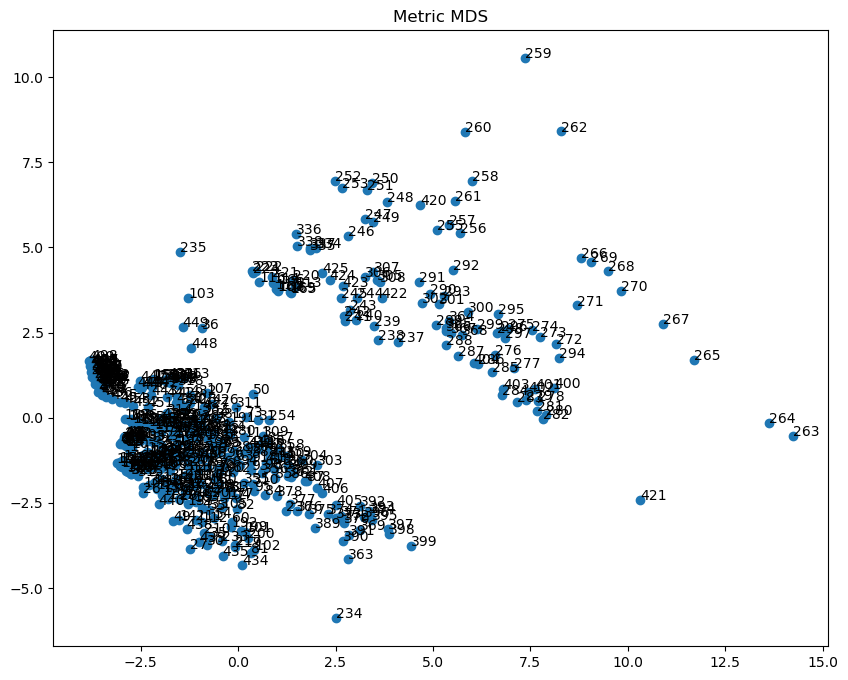

In [42]:
#Plot results
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1])
for i in range(coords.shape[0]):
    plt.text(coords[i, 0], coords[i, 1], str(i))
plt.title('Metric MDS')
plt.show()

In [43]:
#Perform non-metric MDS
nmds = MDS(n_components=2, metric=False, dissimilarity='precomputed', random_state=1)
coords = nmds.fit_transform(dissimilarity)

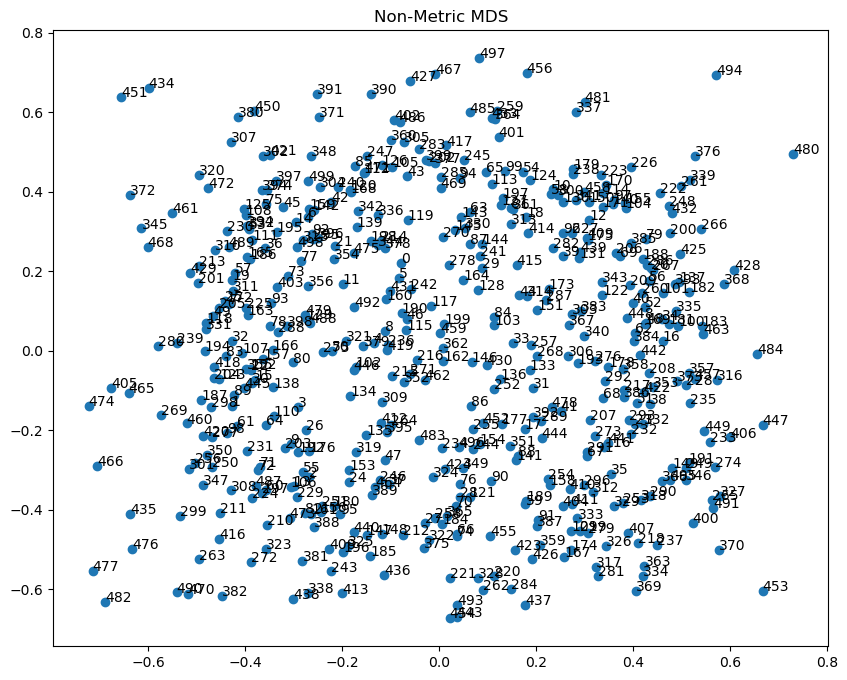

In [44]:
#Plot results
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1])
for i in range(coords.shape[0]):
    plt.text(coords[i, 0], coords[i, 1], str(i))
plt.title('Non-Metric MDS')
plt.show()

In [16]:
#KNN clustering
# Preprocessing

In [18]:
def plot_boundary(x, y, k):
    # Instantiate the model object
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fits the model
    knn.fit(x, y)
    # Step size of the mesh.
    h = .02
    # Plot the decision boundary.
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    # Create Meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict labels for each point in mesh
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    # Reshape to match dimensions
    Z = Z.reshape(xx.shape)
    # Plotting
    plt.contour(xx, yy, Z, cmap=plt.cm.bwr, linestyles = 'dashed', linewidths=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
    plt.title(f'KNN Decision Boundary with {k} Nearest Neighbours')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$', rotation='horizontal')
    plt.show()

In [15]:
#assign a number to each unique activity and form the Y for clustering
names = pd.unique(data['Activities Detailed'].values.ravel())
names = pd.Series(np.arange(len(names)), names)
y = data[['Activities Detailed']].applymap(names.get)

In [16]:
y

Activities Detailed
Time                                  
26.3.2020 9:02:28                    0
26.3.2020 9:02:29                    0
26.3.2020 9:02:30                    0
26.3.2020 9:02:31                    0
26.3.2020 9:02:32                    0
...                                ...
22.6.2022 6:35:10                   20
22.6.2022 6:35:11                   20
22.6.2022 6:35:12                   20
22.6.2022 6:35:13                   20
22.6.2022 6:35:14                   20

[271798 rows x 1 columns]

In [53]:
df_scaled.set_index(y.index, inplace=True)

In [55]:
df_scaled

HR        BR   Posture  Activity  PeakAcceleration  \
Time                                                                          
26.3.2020 9:02:28 -0.153774 -0.462403  0.552528 -0.498877         -0.613343   
26.3.2020 9:02:29 -0.153774 -0.462403  0.552528 -0.498877         -0.030373   
26.3.2020 9:02:30 -0.153774 -0.462403  0.574342 -0.498877         -0.540472   
26.3.2020 9:02:31 -0.153774 -0.462403  0.574342 -0.498877         -0.613343   
26.3.2020 9:02:32 -0.153774 -0.462403  0.574342 -0.636823         -0.613343   
...                     ...       ...       ...       ...               ...   
22.6.2022 6:35:10  0.119997  0.889864 -0.538219 -0.085040         -0.176116   
22.6.2022 6:35:11  0.119997  0.889864 -0.560034 -0.498877         -0.540472   
22.6.2022 6:35:12  0.119997  0.619410 -0.581849 -0.085040          0.625468   
22.6.2022 6:35:13  0.174752  0.619410 -0.625479  0.052905         -0.103244   
22.6.2022 6:35:14  0.174752  0.619410 -0.669109  0.190851         -0.030373   

                   BRAmplitude  ECGAmplitude  ECGNoise  HRConfidence  \
Time                                                                   
26.3.2020 9:02:28    -0.521441     -0.817842 -0.313058      0.252142   
26.3.2020 9:02:29    -0.594433     -0.861610 -0.313058      0.252142   
26.3.2020 9:02:30    -0.631778     -0.861610 -0.313058      0.252142   
26.3.2020 9:02:31    -0.615652     -0.883495 -0.313058      0.252142   
26.3.2020 9:02:32    -0.661144     -0.883495 -0.313058      0.252142   
...                        ...           ...       ...           ...   
22.6.2022 6:35:10     4.396362      0.429561  2.739673     -3.554657   
22.6.2022 6:35:11     5.796793      0.429561  1.768349     -3.900730   
22.6.2022 6:35:12     6.911196      0.429561  2.809053     -4.419839   
22.6.2022 6:35:13     7.382250      0.342024  8.498233     -4.679393   
22.6.2022 6:35:14     5.969428      0.342024  8.151332     -5.111984   

                        HRV  ...  WalkSteps  RunSteps    Bounds  MinorImpacts  \
Time                         ...                                                
26.3.2020 9:02:28 -0.390066  ...  -0.618321 -0.466856 -0.368356     -0.624739   
26.3.2020 9:02:29 -0.390066  ...  -0.618321 -0.466856 -0.368356     -0.624739   
26.3.2020 9:02:30 -0.390066  ...  -0.618321 -0.466856 -0.368356     -0.624739   
26.3.2020 9:02:31 -0.390066  ...  -0.618321 -0.466856 -0.368356     -0.624739   
26.3.2020 9:02:32 -0.390066  ...  -0.618321 -0.466856 -0.368356     -0.624739   
...                     ...  ...        ...       ...       ...           ...   
22.6.2022 6:35:10 -0.569801  ...  -0.622062 -0.466856 -0.368356      0.016210   
22.6.2022 6:35:11 -0.544124  ...  -0.622062 -0.466856 -0.368356      0.016210   
22.6.2022 6:35:12 -0.544124  ...  -0.622062 -0.466856 -0.368356      0.016210   
22.6.2022 6:35:13 -0.518448  ...  -0.622062 -0.466856 -0.368356      0.016210   
22.6.2022 6:35:14 -0.518448  ...  -0.622062 -0.466856 -0.368356      0.016210   

                   MajorImpacts  AvForceDevRate  AvStepImpulse  AvStepPeriod  \
Time                                                                           
26.3.2020 9:02:28     -0.182276       -0.290251      -0.341812     -0.340718   
26.3.2020 9:02:29     -0.182276       -0.290251      -0.341812     -0.340718   
26.3.2020 9:02:30     -0.182276       -0.290251      -0.341812     -0.340718   
26.3.2020 9:02:31     -0.182276       -0.290251      -0.341812     -0.340718   
26.3.2020 9:02:32     -0.182276       -0.290251      -0.341812     -0.340718   
...                         ...             ...            ...           ...   
22.6.2022 6:35:10     -0.182276        3.055563       3.124405      1.978399   
22.6.2022 6:35:11     -0.182276       -0.290251      -0.341812     -0.340718   
22.6.2022 6:35:12     -0.182276       -0.290251      -0.341812     -0.340718   
22.6.2022 6:35:13     -0.182276       -0.290251      -0.341812     -0.340718   
22.6.2022 6:35:14     -0.182276       -0.29025

In [34]:
df_scaled

HR        BR   Posture  BRAmplitude  HRConfidence       HRV  \
0      -0.153774 -0.462403  0.552528    -0.521441      0.252142 -0.390066   
1      -0.153774 -0.462403  0.552528    -0.594433      0.252142 -0.390066   
2      -0.153774 -0.462403  0.574342    -0.631778      0.252142 -0.390066   
3      -0.153774 -0.462403  0.574342    -0.615652      0.252142 -0.390066   
4      -0.153774 -0.462403  0.574342    -0.661144      0.252142 -0.390066   
...          ...       ...       ...          ...           ...       ...   
271793  0.119997  0.889864 -0.538219     4.396362     -3.554657 -0.569801   
271794  0.119997  0.889864 -0.560034     5.796793     -3.900730 -0.544124   
271795  0.119997  0.619410 -0.581849     6.911196     -4.419839 -0.544124   
271796  0.174752  0.619410 -0.625479     7.382250     -4.679393 -0.518448   
271797  0.174752  0.619410 -0.669109     5.969428     -5.111984 -0.518448   

        ImpulseLoad  WalkSteps  RunSteps    Bounds  MinorImpacts  \
0         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
1         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
2         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
3         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
4         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
...             ...        ...       ...       ...           ...   
271793    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   
271794    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   
271795    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   
271796    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   
271797    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   

        MajorImpacts  PeakAccelPhi  peakAccelTheta  
0          -0.182276      0.509910       -0.630600  
1          -0.182276      0.660056       -0.962345  
2          -0.182276      0.539939       -0.603702  
3          -0.182276      0.509910       -0.567838  
4          -0.182276      0.509910       -0.630600  
...              ...           ...             ...  
271793     -0.182276     -0.180758        0.633616  
271794     -0.182276     -0.120700        0.633616  
271795     -0.182276     -0.390962        0.669480  
271796     -0.182276     -0.330904        0.669480  
271797     -0.182276     -0.360933        0.705345  

[271798 rows x 14 columns]

C:\Users\DavidovB\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


NameError: name 'X' is not defined

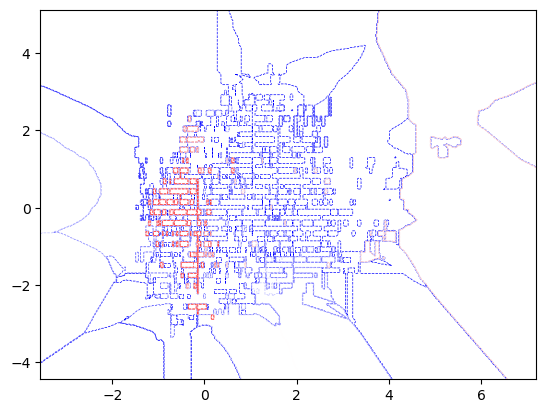

In [35]:
# Plot KNN decision boundary with K=5
plot_boundary(df_scaled[['HR','BR']].values, y, 5)

In [8]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(non_binary_columns)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [39]:
principalComponents2.components_

array([[ 9.81164331e-04, -4.34678720e-05,  7.25291625e-04,
         2.69142854e-06,  4.76047588e-06,  9.80483239e-01,
         4.17521866e-09,  1.36138112e-08, -4.76142010e-04,
         2.18697701e-04,  9.22420081e-06,  1.85576601e-01,
         6.48650583e-02,  4.84927876e-04,  3.70227015e-05,
        -1.25742585e-05,  4.12103913e-06,  9.59341674e-04,
        -1.88278174e-03]])

In [13]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [14]:
finalDf.head(3)

principal component 1  principal component 2  Activities Detailed
0           -3683.773328           -2747.966808                    0
1           -4105.306661           -2663.389896                    0
2           -4321.091397           -2620.205948                    0

In [18]:
transformed_data = pca.transform(non_binary_columns)

In [19]:
explained_variance_ratio = pca.explained_variance_ratio_

In [20]:
n_components_selected = pca.n_components_

In [21]:
n_components_selected

15

In [22]:
# Interpret the components
for i, component in enumerate(components):
    print(f"Principal Component {i+1}:")
    for j, feature in enumerate(component):
        print(f"Feature {j+1}: {feature:.4f}")
    print()

NameError: name 'components' is not defined

In [48]:
components = pca.components_

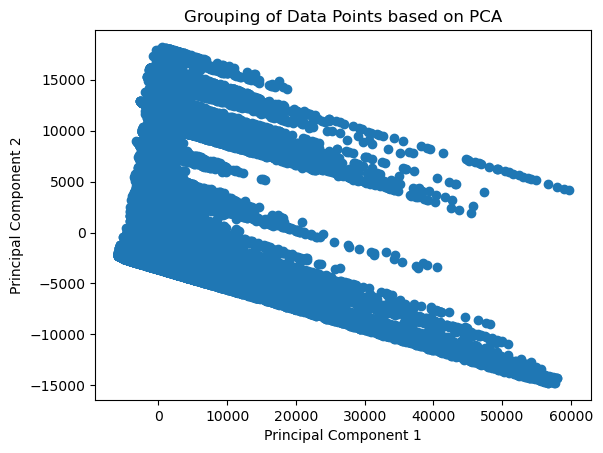

In [52]:
# Plotting the transformed data
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Grouping of Data Points based on PCA')
plt.show()

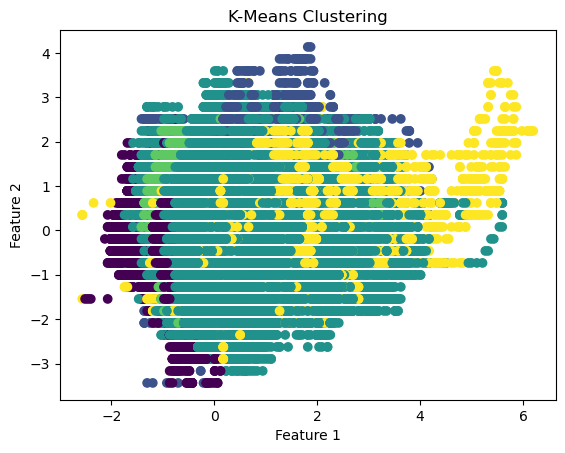

In [56]:
data_cluster = df_scaled.values
# Define the number of clusters
num_clusters = 5

# Initialize and fit the k-means model
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data_cluster)

# Access the cluster labels
cluster_labels = kmeans.labels_

# Plotting the clustered data
plt.scatter(data_cluster[:, 0], data_cluster[:, 1], c=cluster_labels)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.show()

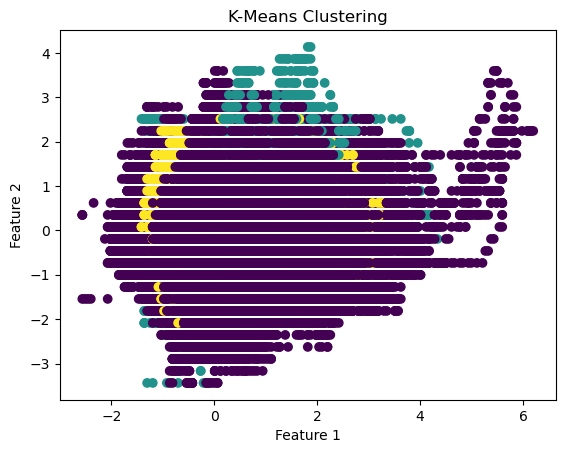

In [53]:
# Initialize and fit the k-means model
data_cluster = df_scaled.values
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_cluster)

# Access the cluster labels
cluster_labels = kmeans.labels_

# Plotting the clustered data
plt.scatter(data_cluster[:, 0], data_cluster[:, 1], c=cluster_labels)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.show()

In [51]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=non_binary_columns.columns)

# Analyze the differences in feature values across the centroids
feature_importance = centroids.std().sort_values(ascending=False)

# Print the feature importance
print("Feature Importance:")
print(feature_importance)

Feature Importance:
MajorImpacts      1.889668
HRConfidence      1.691881
Bounds            1.585068
RunSteps          1.526861
WalkSteps         1.303204
ImpulseLoad       1.273852
Posture           0.933482
MinorImpacts      0.916280
PeakAccelPhi      0.913813
HRV               0.694005
HR                0.606627
BRAmplitude       0.552633
BR                0.502474
peakAccelTheta    0.204538
dtype: float64


## Apply t-sne on the data for 2D visualization

In [80]:
from sklearn.manifold import TSNE

In [111]:
#choose only numerical data for correlation
columns_to_exclude = ['Year','Month', 'Weekday', 'Hour', 'Date','Activities','Name of the volunteer']
numerical_columns  = data.drop(columns=columns_to_exclude)

# Get the numeric columns including "Activities Detailed" column
numeric_columns = numerical_columns.select_dtypes(include=[np.number, "object"])

non_binary_columns = numerical_columns.loc[:, ~(numerical_columns.isin([0, 1])).all()]  # Exclude columns with only 0s and 1s
# Exclude these columns as they don't provide important information

In [112]:
non_binary_columns.columns

Index(['HR', 'BR', 'Posture', 'Activity', 'PeakAcceleration', 'BRAmplitude',
       'ECGAmplitude', 'ECGNoise', 'HRConfidence', 'HRV', 'CoreTemp',
       'ImpulseLoad', 'WalkSteps', 'RunSteps', 'Bounds', 'MinorImpacts',
       'MajorImpacts', 'AvForceDevRate', 'AvStepImpulse', 'AvStepPeriod',
       'PeakAccelPhi', 'peakAccelTheta', 'Activities Detailed'],
      dtype='object')

In [125]:
len(non_binary_columns['Activities Detailed'].unique())

20

In [113]:
# Assuming you have a DataFrame named 'X_pre_tsne' and you want to select 'n' random rows per label
n = 500  # Number of random rows per label

# Group the dataframe by the 'Activities Detailed' column
grouped = non_binary_columns.groupby('Activities Detailed')

# Create an empty DataFrame to store the subdataframe
subdataframe = pd.DataFrame()

# Iterate over each group
for label, group_df in grouped:
    # Get the number of available rows for the current label
    available_rows = len(group_df)

    # Calculate the number of rows to sample (min between 'n' and available rows)
    rows_to_sample = min(n, available_rows)

    # Randomly sample rows from the current group
    random_rows = group_df.sample(rows_to_sample, replace=rows_to_sample > available_rows, random_state=42)

    # Replicate rows if necessary
    if rows_to_sample > available_rows:
        repetitions = rows_to_sample // available_rows
        random_rows = pd.concat([random_rows] * repetitions, ignore_index=True)
        remaining_rows = rows_to_sample % available_rows
        random_rows = pd.concat([random_rows, group_df.sample(remaining_rows, random_state=42)], ignore_index=True)

    # Append the random rows to the subdataframe
    subdataframe = pd.concat([subdataframe, random_rows], ignore_index=True)

# Reset the index of the subdataframe
subdataframe = subdataframe.reset_index(drop=True)

In [99]:
len(subdataframe)

9372

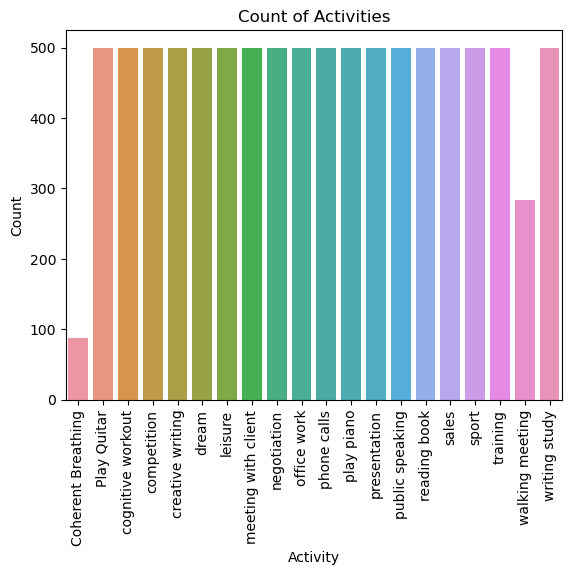

In [100]:
plt.title('No of Datapoints per Activity', fontsize=15)
sns.countplot(data=subdataframe, x='Activities Detailed')
plt.title('Count of Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.show()

In [114]:
X_pre_tsne = subdataframe.drop('Activities Detailed', axis=1)
y_pre_tsne = subdataframe['Activities Detailed']

In [115]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [116]:
X_pre_tsne = feature_normalize(X_pre_tsne)

In [117]:
X_pre_tsne.sample()

HR        BR  Posture  Activity  PeakAcceleration  BRAmplitude  \
8683  0.714213  0.067929 -0.04047  3.378852          3.551664    -0.536607   

      ECGAmplitude  ECGNoise  HRConfidence       HRV  ...  WalkSteps  \
8683      0.902735  0.051423      0.301111  1.638864  ...   2.873653   

      RunSteps    Bounds  MinorImpacts  MajorImpacts  AvForceDevRate  \
8683  2.655997  4.708831     -0.613589     -0.082266        4.262641   

      AvStepImpulse  AvStepPeriod  PeakAccelPhi  peakAccelTheta  
8683       2.829835      3.853274      0.632395       -1.110429  

[1 rows x 22 columns]

In [126]:
import seaborn as sns

def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
    colors = sns.color_palette('tab20', n_colors=20)  # Choose a larger color palette

    for index, perplexity in enumerate(perplexities):
        # Perform t-SNE
        print('\nPerforming t-SNE with perplexity {} and {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('Done..')

        # Prepare the data for seaborn
        print('Creating plot for this t-SNE visualization..')
        df = pd.DataFrame({'x': X_reduced[:, 0], 'y': X_reduced[:, 1], 'label': y_data})

        # Get the unique levels in the 'label' column
        unique_labels = df['label'].unique()

        # Create a dictionary mapping each level to a color
        color_dict = dict(zip(unique_labels, colors[:len(unique_labels)]))

        # Map the colors to the 'label' column
        df['color'] = df['label'].map(color_dict)

        # Draw the plot
        plt.figure(figsize=(14, 10))
        sns.scatterplot(data=df, x='x', y='y', hue='label', style='label', palette=color_dict, markers=True)
        plt.title("Perplexity: {} and Max_iter: {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('Saving this plot as an image in the present working directory...')
        plt.savefig(img_name)
        plt.show()
        print('Done')


Performing t-SNE with perplexity 2 and 1000 iterations at max
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 9372 samples in 0.004s...


C:\Users\DavidovB\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\DavidovB\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9372 samples in 0.807s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9372
[t-SNE] Computed conditional probabilities for sample 2000 / 9372
[t-SNE] Computed conditional probabilities for sample 3000 / 9372
[t-SNE] Computed conditional probabilities for sample 4000 / 9372
[t-SNE] Computed conditional probabilities for sample 5000 / 9372
[t-SNE] Computed conditional probabilities for sample 6000 / 9372
[t-SNE] Computed conditional probabilities for sample 7000 / 9372
[t-SNE] Computed conditional probabilities for sample 8000 / 9372
[t-SNE] Computed conditional probabilities for sample 9000 / 9372
[t-SNE] Computed conditional probabilities for sample 9372 / 9372
[t-SNE] Mean sigma: 0.097846
[t-SNE] Computed conditional probabilities in 0.084s
[t-SNE] Iteration 50: error = 127.1382751, gradient norm = 0.0264003 (50 iterations in 7.258s)
[t-SNE] Iteration 100: error = 107.6990204, gradient norm = 0.0208954 (50 iterations in 4.782s)
[t-SNE] It

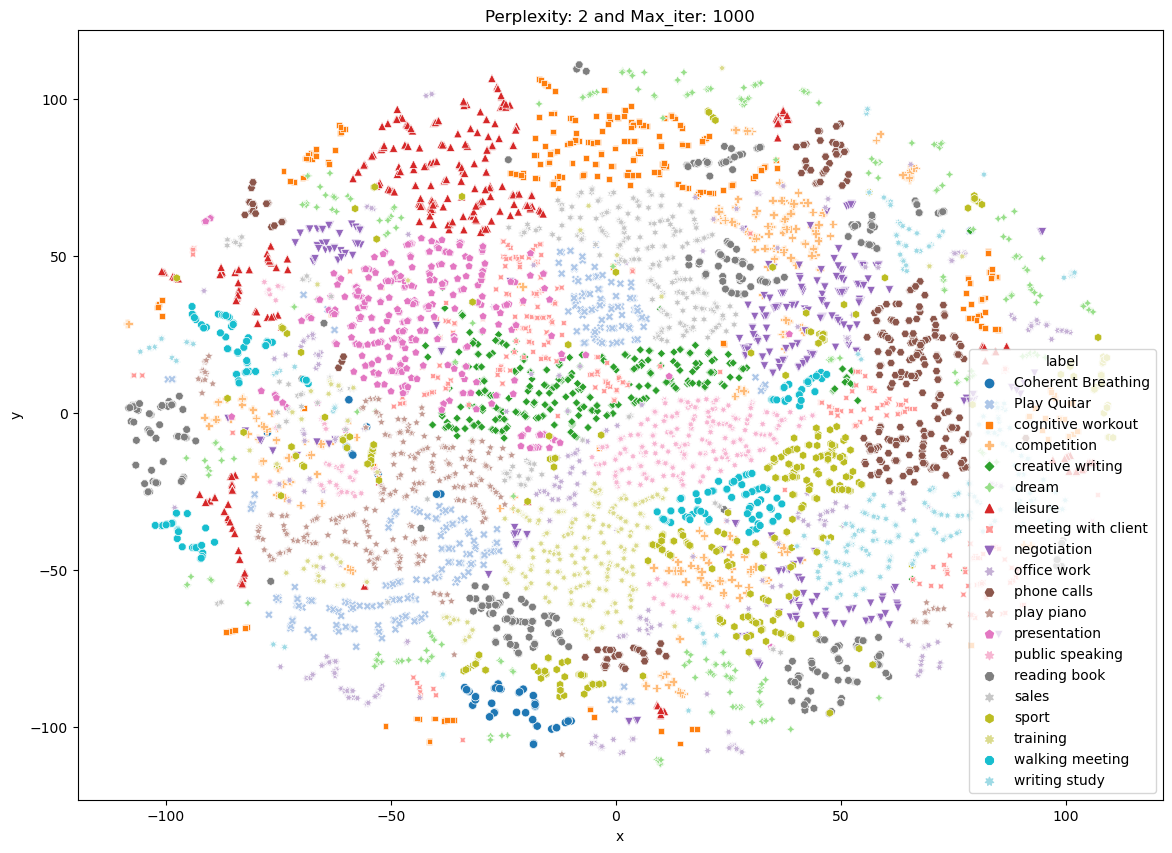

Done

Performing t-SNE with perplexity 5 and 1000 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 9372 samples in 0.004s...


C:\Users\DavidovB\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\DavidovB\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9372 samples in 0.824s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9372
[t-SNE] Computed conditional probabilities for sample 2000 / 9372
[t-SNE] Computed conditional probabilities for sample 3000 / 9372
[t-SNE] Computed conditional probabilities for sample 4000 / 9372
[t-SNE] Computed conditional probabilities for sample 5000 / 9372
[t-SNE] Computed conditional probabilities for sample 6000 / 9372
[t-SNE] Computed conditional probabilities for sample 7000 / 9372
[t-SNE] Computed conditional probabilities for sample 8000 / 9372
[t-SNE] Computed conditional probabilities for sample 9000 / 9372
[t-SNE] Computed conditional probabilities for sample 9372 / 9372
[t-SNE] Mean sigma: 0.188939
[t-SNE] Computed conditional probabilities in 0.185s
[t-SNE] Iteration 50: error = 116.4063110, gradient norm = 0.0216218 (50 iterations in 10.201s)
[t-SNE] Iteration 100: error = 96.2781677, gradient norm = 0.0111612 (50 iterations in 5.890s)
[t-SNE] It

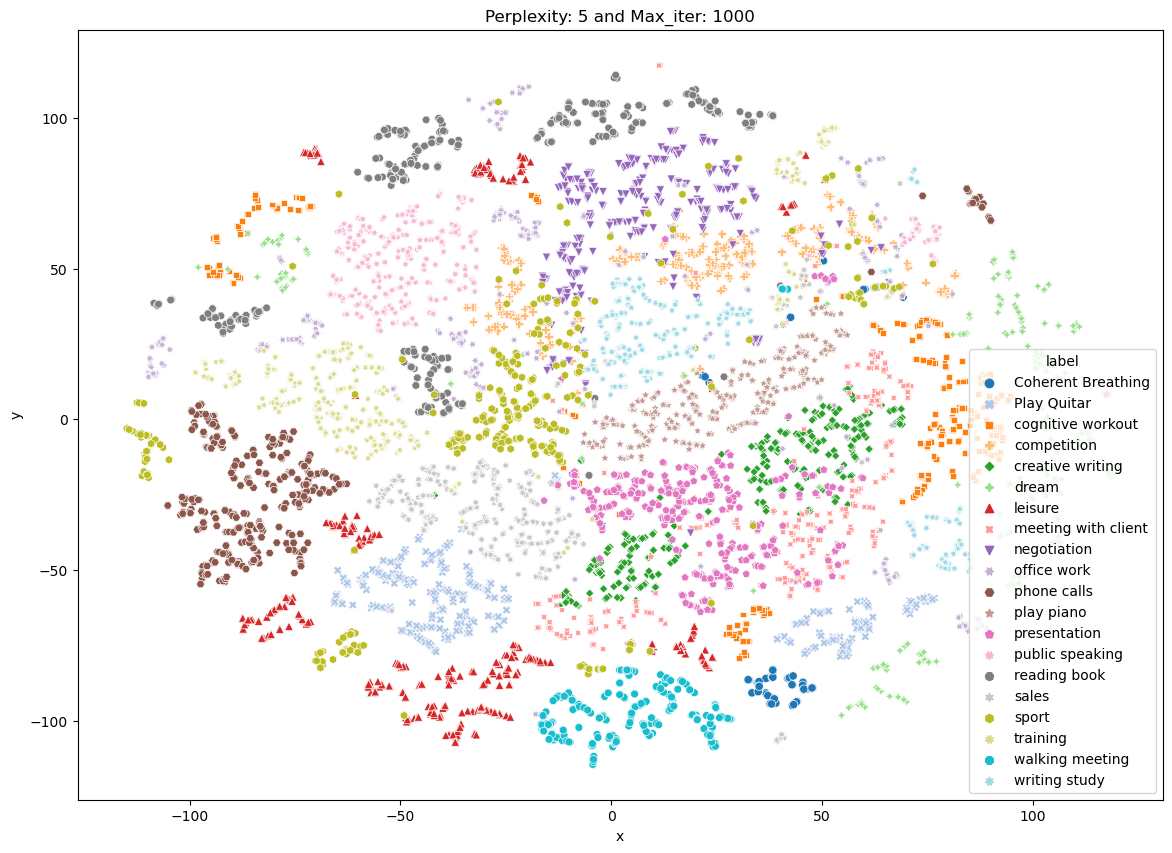

Done

Performing t-SNE with perplexity 10 and 1000 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 9372 samples in 0.004s...


C:\Users\DavidovB\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\DavidovB\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9372 samples in 0.981s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9372
[t-SNE] Computed conditional probabilities for sample 2000 / 9372
[t-SNE] Computed conditional probabilities for sample 3000 / 9372
[t-SNE] Computed conditional probabilities for sample 4000 / 9372
[t-SNE] Computed conditional probabilities for sample 5000 / 9372
[t-SNE] Computed conditional probabilities for sample 6000 / 9372
[t-SNE] Computed conditional probabilities for sample 7000 / 9372
[t-SNE] Computed conditional probabilities for sample 8000 / 9372
[t-SNE] Computed conditional probabilities for sample 9000 / 9372
[t-SNE] Computed conditional probabilities for sample 9372 / 9372
[t-SNE] Mean sigma: 0.250883
[t-SNE] Computed conditional probabilities in 0.282s
[t-SNE] Iteration 50: error = 107.7406616, gradient norm = 0.0208808 (50 iterations in 11.458s)
[t-SNE] Iteration 100: error = 87.8345795, gradient norm = 0.0082843 (50 iterations in 5.572s)
[t-SNE] It

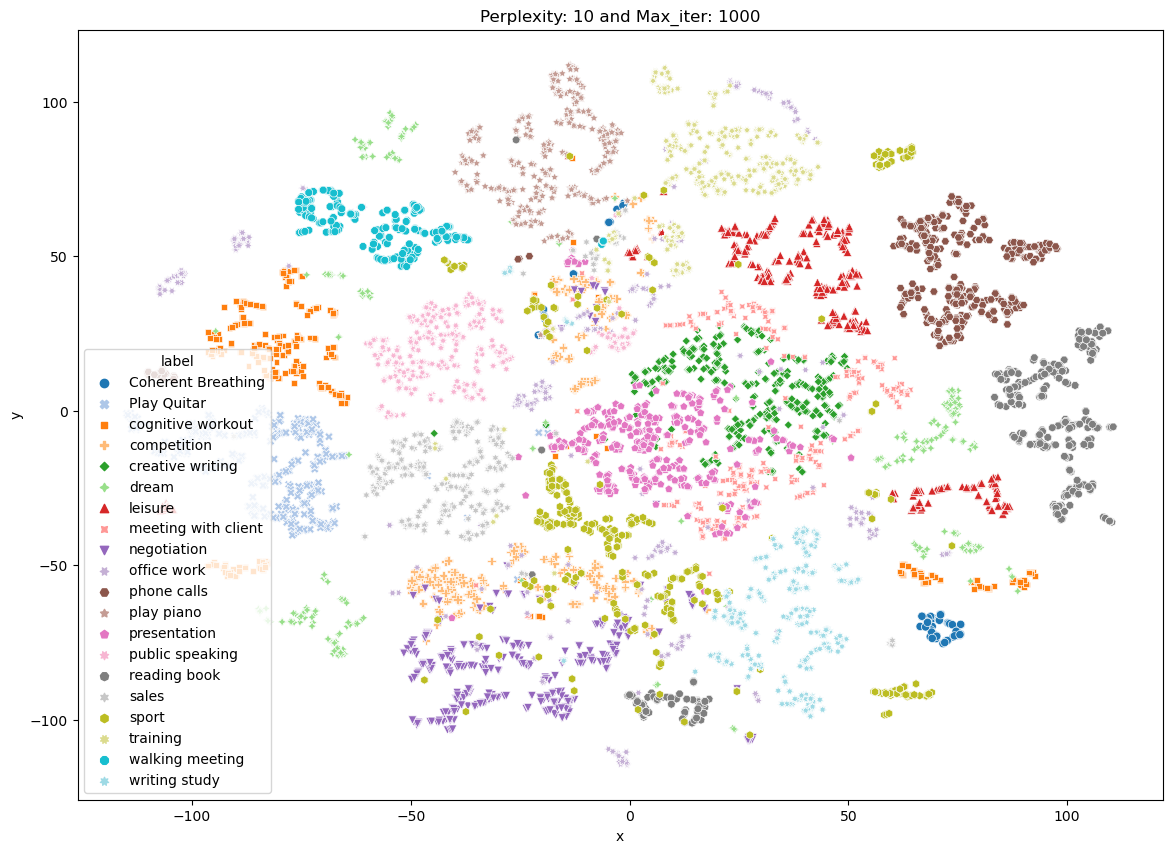

Done


In [127]:
perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[2,5,10])

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [72]:
import pywt
import pandas as pd
import numpy as np

def apply_wavelet_transform(df, label_column, wavelet_family, decomposition_level):
    # Step 1: Prepare the Data
    features = df.drop(label_column, axis=1)  # DataFrame containing only the features
    labels = df[label_column]  # Series containing the labels

    # Step 2: Apply Wavelet Transform
    transformed_features = pd.DataFrame()  # DataFrame to store the transformed features

    for col in features.columns:
        coeffs = pywt.wavedec(features[col], wavelet_family, level=decomposition_level)
        for i in range(len(coeffs)):
            transformed_features[f"{col}_c{i+1}"] = coeffs[i]

    # Step 3: Select Significant Coefficients (Optional)
    # You can implement your own logic here to select significant coefficients

    # Step 4: Reconstruct Data
    reconstructed_features = pd.DataFrame()  # DataFrame to store the reconstructed features

    for col in transformed_features.columns:
        reconstructed_features[col] = pywt.waverec(transformed_features[col], wavelet_family)

    # Step 5: Combine with Labels
    reconstructed_df = reconstructed_features.copy()
    reconstructed_df[label_column] = labels

    return reconstructed_df

In [ ]:
reconstructed_df = apply_wavelet_transform(df, "label", "db4", 3)

In [74]:
df_scaled

HR        BR   Posture  BRAmplitude  HRConfidence       HRV  \
0      -0.153774 -0.462403  0.552528    -0.521441      0.252142 -0.390066   
1      -0.153774 -0.462403  0.552528    -0.594433      0.252142 -0.390066   
2      -0.153774 -0.462403  0.574342    -0.631778      0.252142 -0.390066   
3      -0.153774 -0.462403  0.574342    -0.615652      0.252142 -0.390066   
4      -0.153774 -0.462403  0.574342    -0.661144      0.252142 -0.390066   
...          ...       ...       ...          ...           ...       ...   
271793  0.119997  0.889864 -0.538219     4.396362     -3.554657 -0.569801   
271794  0.119997  0.889864 -0.560034     5.796793     -3.900730 -0.544124   
271795  0.119997  0.619410 -0.581849     6.911196     -4.419839 -0.544124   
271796  0.174752  0.619410 -0.625479     7.382250     -4.679393 -0.518448   
271797  0.174752  0.619410 -0.669109     5.969428     -5.111984 -0.518448   

        ImpulseLoad  WalkSteps  RunSteps    Bounds  MinorImpacts  \
0         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
1         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
2         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
3         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
4         -0.637869  -0.618321 -0.466856 -0.368356     -0.624739   
...             ...        ...       ...       ...           ...   
271793    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   
271794    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   
271795    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   
271796    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   
271797    -0.639455  -0.622062 -0.466856 -0.368356      0.016210   

        MajorImpacts  PeakAccelPhi  peakAccelTheta  
0          -0.182276      0.509910       -0.630600  
1          -0.182276      0.660056       -0.962345  
2          -0.182276      0.539939       -0.603702  
3          -0.182276      0.509910       -0.567838  
4          -0.182276      0.509910       -0.630600  
...              ...           ...             ...  
271793     -0.182276     -0.180758        0.633616  
271794     -0.182276     -0.120700        0.633616  
271795     -0.182276     -0.390962        0.669480  
271796     -0.182276     -0.330904        0.669480  
271797     -0.182276     -0.360933        0.705345  

[271798 rows x 14 columns]

## Group by activity

In [36]:
groups = data.groupby('Activities Detailed')

# Iterate over each group and create separate DataFrames
smaller_dfs = []
for label, group_df in groups:
    smaller_dfs.append(group_df.copy())

In [106]:
coherent_breathing = smaller_dfs[0]

In [107]:
coherent_breathing.index = pd.to_datetime(coherent_breathing.index, format='%d.%m.%Y %H:%M:%S')

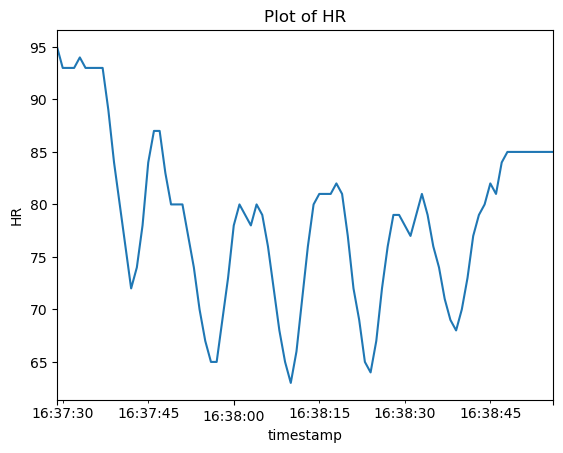

In [109]:
coherent_breathing['HR'].plot()
plt.xlabel('timestamp')
plt.ylabel('HR')
plt.title('Plot of HR')
plt.show()

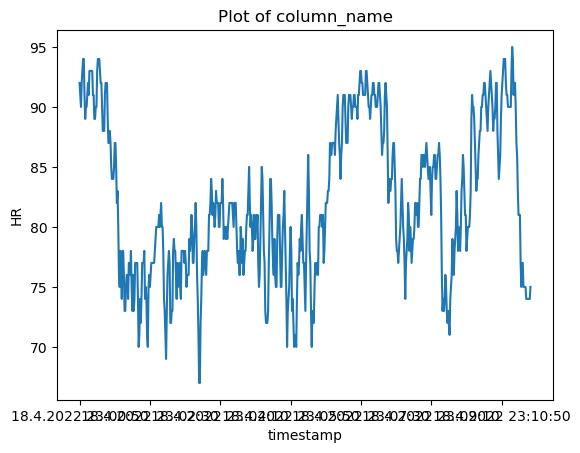

In [110]:
play_quitar = smaller_dfs[1]

play_quitar['HR'].plot()
plt.xlabel('timestamp')
plt.ylabel('HR')
plt.title('Plot of column_name')
plt.show()

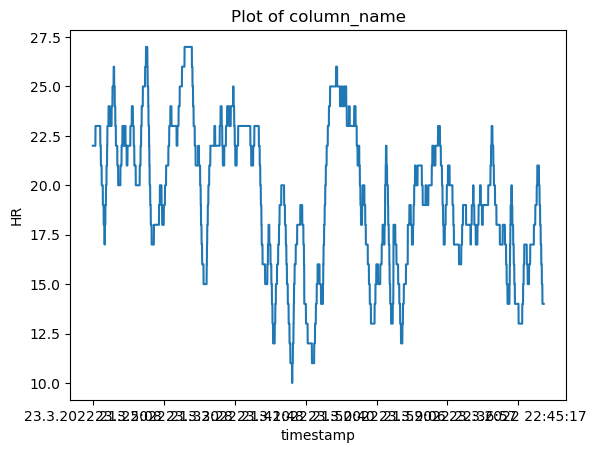

In [118]:

play_quitar['BR'].plot()
plt.xlabel('timestamp')
plt.ylabel('HR')
plt.title('Plot of column_name')
plt.show()

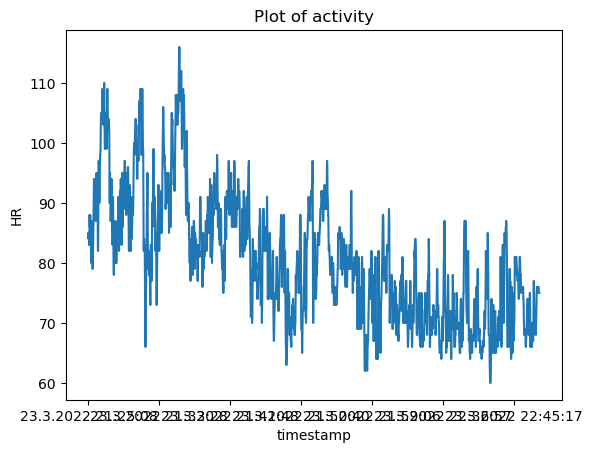

In [119]:
phone_calls = smaller_dfs[11]

phone_calls['HR'].plot()
plt.xlabel('timestamp')
plt.ylabel('HR')
plt.title('Plot of activity')
plt.show()

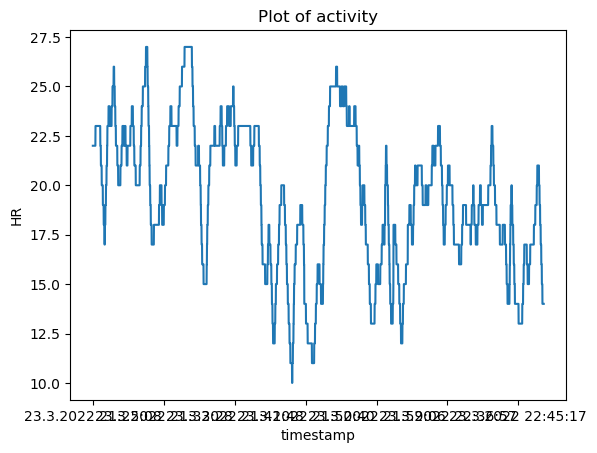

In [120]:


phone_calls['BR'].plot()
plt.xlabel('timestamp')
plt.ylabel('HR')
plt.title('Plot of activity')
plt.show()

## Partitions

In [142]:
# Assuming you have already executed the code up to creating the `smaller_dfs` list
import math

partitioned_dfs = []

# Iterate over each smaller DataFrame
for df in smaller_dfs:
    if isinstance(df, pd.DataFrame):  # Check if the element is a DataFrame
        num_partitions = math.ceil(len(df) / 1500)

        # Partition the DataFrame into chunks of 1500 rows
        partitions = [df[i * 1500:(i + 1) * 1500].copy() for i in range(num_partitions)]

        # Append the partitions to the list
        partitioned_dfs.extend(partitions)

In [143]:
import math

def partition_dataframes(smaller_dfs):
    partitioned_dfs = []

    # Iterate over each smaller DataFrame
    for df in smaller_dfs:
        if isinstance(df, pd.DataFrame):  # Check if the element is a DataFrame
            num_partitions = math.ceil(len(df) / 1500)

            # Partition the DataFrame into chunks of 1500 rows
            partitions = [df[i * 1500:(i + 1) * 1500].copy() for i in range(num_partitions)]

            # Append the partitions to the list
            partitioned_dfs.extend(partitions)

    return partitioned_dfs

In [144]:
partition_dataframes(smaller_dfs)

[]